<a href="https://colab.research.google.com/github/bjatkin/GettingIntoGAN/blob/main/GettingIntoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REFERENCE



*  https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py
*  https://github.com/eriklindernoren/PyTorch-GAN#gan



# IMPORTS

This is where we'll import all the different libraries we'll need for our GAN to work.

In [ ]:
# pytorch as well as some sub modules for convenience
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision will help us get MNIST all set up 
import torchvision
import torchvision.transforms as transforms

# numpy cause of course
import numpy as np

# for debugging
import pdb

# for visulizing our results
# matplotlib is super versatile
# can be useful for all kinds of data
# vis stuff
import matplotlib.pyplot as plt

# MNIST

This is the MNIST dataset. We set the basic parameters here, such as batch size, normalization mean, and normalization std.

In [ ]:
kwargs = {'batch_size': 64, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
mnist_means = torch.tensor([0.5])
mnist_stds = torch.tensor([0.5])

trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mnist_means, mnist_stds),
])

# we only need the training set because we're not actually using the training labels
mnist_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist/data', train=True, download=True, transform=trans),
  **kwargs
)

torch.Size([64, 1, 28, 28])


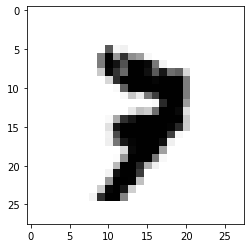

In [ ]:
img, _ = next(iter(mnist_loader))
print(img.size())
plt.imshow(img[0][0], cmap='Greys')
plt.show()

# GENERATOR

Here is where we define the generator network. We'll do a simple linear network, since that will be the easiest to train.

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    layers = [
      nn.Linear(100, 128),
      nn.BatchNorm1d(128),
      nn.ReLU(),

      nn.Linear(128, 256),
      nn.BatchNorm1d(256),
      nn.ReLU(),

      nn.Linear(256, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),


      nn.Linear(512, 1024),
      nn.BatchNorm1d(1024),
      nn.ReLU(),

      nn.Linear(1024, 28*28),
      # finish with a tanh to improve numerical stability
      nn.Tanh()
    ]

    self.net = nn.Sequential(*layers)

  def forward(self, z):
    batch = z.size(0)
    img = self.net(z)

    # this needs to be reshaped to the same size as MNIST
    return img.view(batch, 28, 28)

# DISCRIMINATOR

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    layers = [
      nn.Linear(28*28, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512, 256),
      nn.BatchNorm1d(256),
      nn.ReLU(),

      nn.Linear(256, 1),

      # again, this improves the stability of the GAN
      # and will play better with the BCELoss
      nn.Sigmoid(),
    ]

    self.net = nn.Sequential(*layers)

  def forward(self, x):
    batch = x.size(0)

    # flatten out the input for the MLP
    return self.net(x.view(batch, -1))

In [ ]:
# do lots of intermediate steps to make sure stuff is working
# code is hard, DNN code is REALLY HARD

for img, _ in mnist_loader:
  print("traing image size", img.size())
  break

z = torch.randn((32, 100)).cuda()
gen = Generator().cuda()
disc = Discriminator().cuda()

# test the full system with a z vector
img_hat = gen(z)
print("gen image size", img_hat.size())
fake = disc(img_hat)
print("fake:", fake)

# test the discriminator with real data
img, _ = next(iter(mnist_loader))
img = img.cuda()
real = disc(img)
print("real:", real)

traing image size torch.Size([64, 1, 28, 28])
gen image size torch.Size([32, 28, 28])
fake: tensor([[0.6043],
        [0.5577],
        [0.6097],
        [0.6076],
        [0.5913],
        [0.6515],
        [0.6137],
        [0.6390],
        [0.5831],
        [0.6006],
        [0.6767],
        [0.7700],
        [0.4996],
        [0.6978],
        [0.6225],
        [0.6561],
        [0.7644],
        [0.6516],
        [0.6670],
        [0.7351],
        [0.5060],
        [0.3697],
        [0.7224],
        [0.6775],
        [0.4654],
        [0.5599],
        [0.6426],
        [0.5936],
        [0.6115],
        [0.6512],
        [0.6251],
        [0.6987]], device='cuda:0', grad_fn=<SigmoidBackward>)
real: tensor([[0.5889],
        [0.6157],
        [0.7032],
        [0.6053],
        [0.5976],
        [0.5624],
        [0.5959],
        [0.6791],
        [0.5368],
        [0.6662],
        [0.6801],
        [0.6801],
        [0.6879],
        [0.4386],
        [0.7008],
        [0.

# VIS CODE

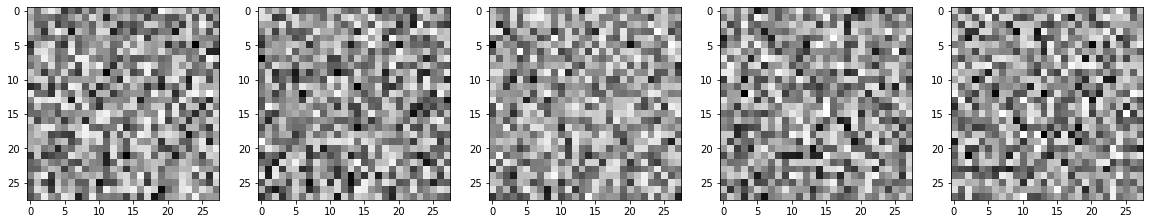

In [ ]:
# make sure to reverse the normalization of the data. it dosen't matter much in this
# case, but if you generate color images or other types of data, it will make a significant
# difference in the final result.
un_normalize = transforms.Normalize((-mnist_means / mnist_stds), (1.0 / mnist_stds))

# make sure to have code to visualize the results; losses durring GAN
# training can be really hard to interperate and are often not very useful.
# if your gan is working you should be able to see the results improving
# as training happens.
def sample_images(gen, size):
  batch = np.prod(size)
  z = torch.randn((batch, 100)).clamp(-3, 3).cuda()
  img = gen(z)
  img = un_normalize(img)
  fig, axs = plt.subplots(1, size)
  fig.set_figwidth(20)

  for i in range(size):
    axs[i].imshow(img[i].squeeze().detach().cpu(), cmap="Greys")
  plt.show()


# lots of little tests to make sure stuff it working
net = Generator()
sample_images(gen, 5)

# TRAIN

In [ ]:
def train(gen, epochs):
  # set up our loss function and the generator and discriminator
  loss_fn = nn.BCELoss().cuda()
  gen = gen.cuda()
  disc = Discriminator().cuda()

  # set up the optimizers
  optim_G = optim.Adam(gen.parameters(), lr=0.0002)
  optim_D = optim.Adam(disc.parameters(), lr=0.0002)

  for epoch in range(epochs):
    for imgs, _ in mnist_loader:
      batch = imgs.size(0)
      imgs = imgs.cuda()

      # labels for our loss function
      real = torch.ones((batch, 1), requires_grad=False).cuda()
      fake = torch.zeros((batch, 1), requires_grad=False).cuda()

      # train the generator
      optim_G.zero_grad()

      z = torch.randn((batch, 100)).cuda()
      gen_imgs = gen(z)

      g_loss = loss_fn(disc(gen_imgs), real)

      g_loss.backward()
      optim_G.step()

      # train the discriminator
      optim_D.zero_grad()

      # we need to calculate both a real loss as well as a fake loss
      real_loss = loss_fn(disc(imgs), real)
      fake_loss = loss_fn(disc(gen_imgs.detach()), fake)
      # take the average of the two
      d_loss = (real_loss + fake_loss) / 2

      d_loss.backward()
      optim_D.step()

    # for every epoch, let's print out some results to see how things are going
    print("{}/{} GEN_LOSS {:.4f} DISC_LOSS {:.4f}({:.2f})({:.2f})".format(epoch+1, epochs, g_loss, d_loss, real_loss, fake_loss))
    sample_images(gen, 5)

1/200 GEN_LOSS 1.6831 DISC_LOSS 0.5101(0.74)(0.28)


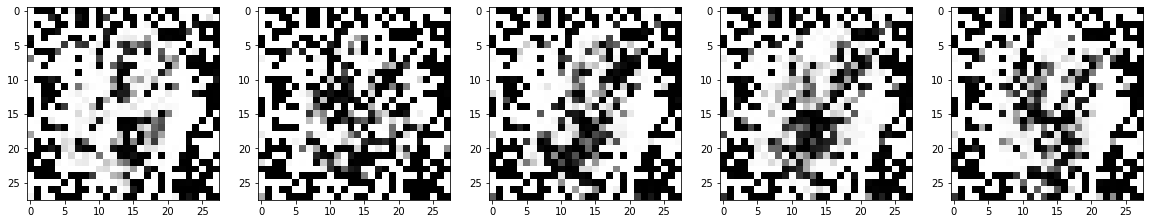

2/200 GEN_LOSS 2.1075 DISC_LOSS 0.4913(0.81)(0.17)


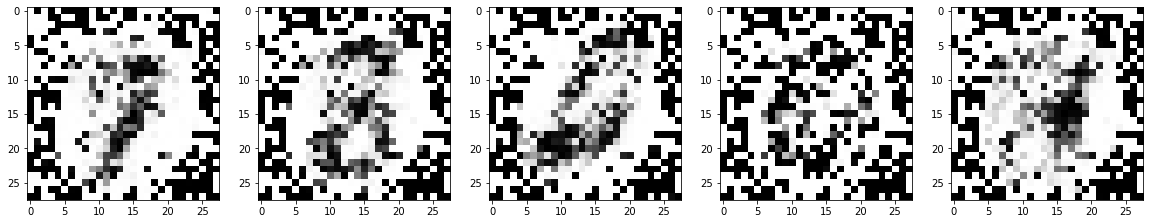

3/200 GEN_LOSS 2.1006 DISC_LOSS 0.2714(0.33)(0.21)


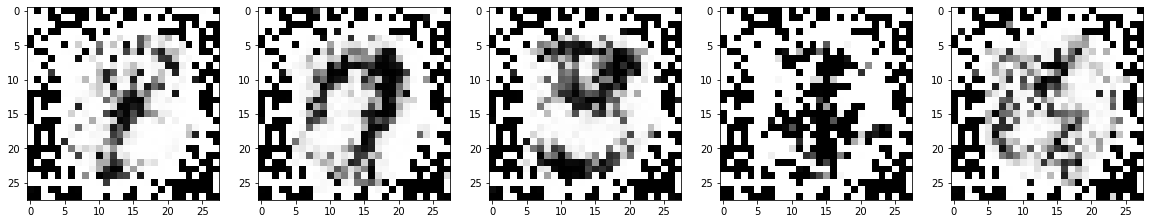

4/200 GEN_LOSS 2.2951 DISC_LOSS 0.2943(0.37)(0.22)


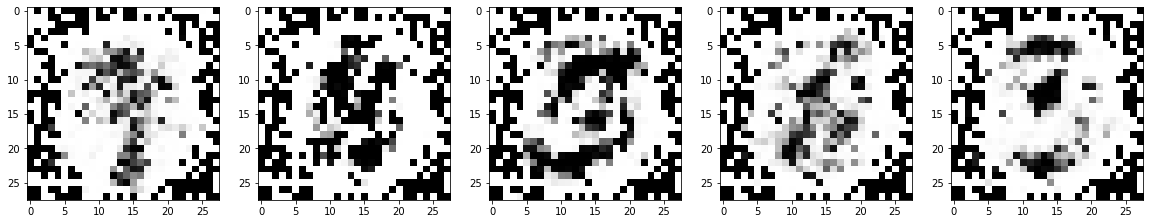

5/200 GEN_LOSS 2.9308 DISC_LOSS 0.1842(0.25)(0.12)


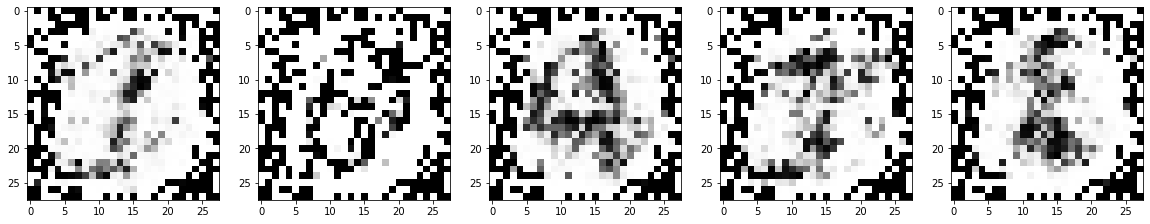

6/200 GEN_LOSS 2.7885 DISC_LOSS 0.6462(1.17)(0.13)


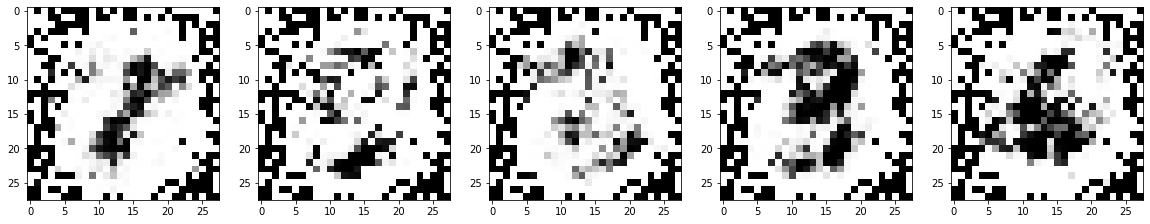

7/200 GEN_LOSS 2.3750 DISC_LOSS 0.1659(0.16)(0.18)


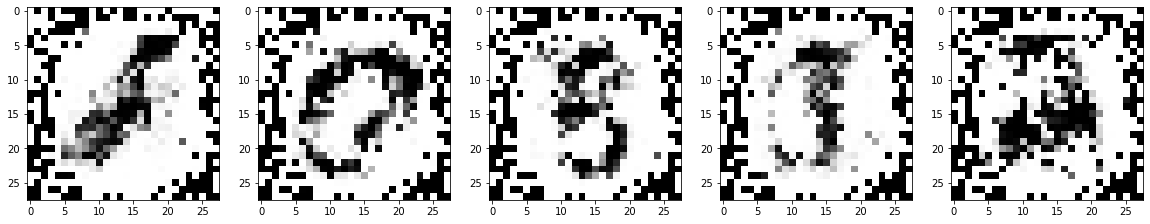

8/200 GEN_LOSS 2.7356 DISC_LOSS 0.1339(0.15)(0.12)


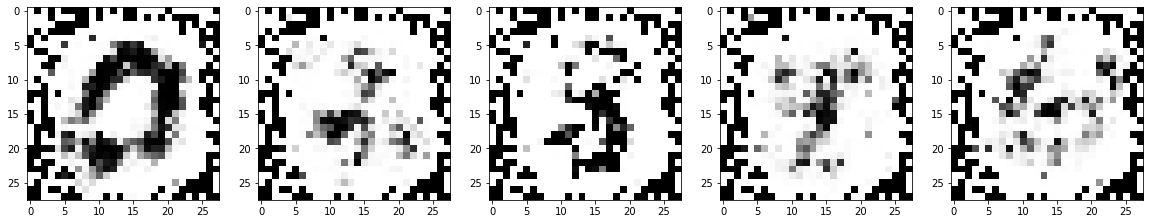

9/200 GEN_LOSS 2.2499 DISC_LOSS 0.2095(0.16)(0.26)


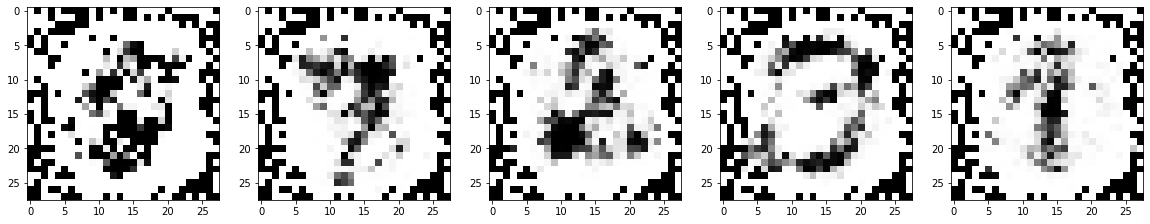

10/200 GEN_LOSS 2.9149 DISC_LOSS 0.3083(0.49)(0.12)


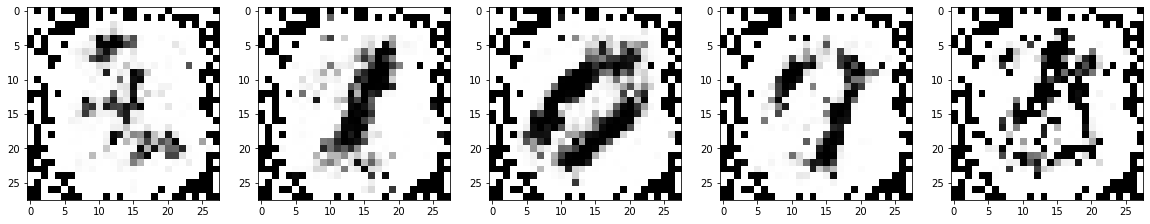

11/200 GEN_LOSS 2.7324 DISC_LOSS 0.1412(0.18)(0.11)


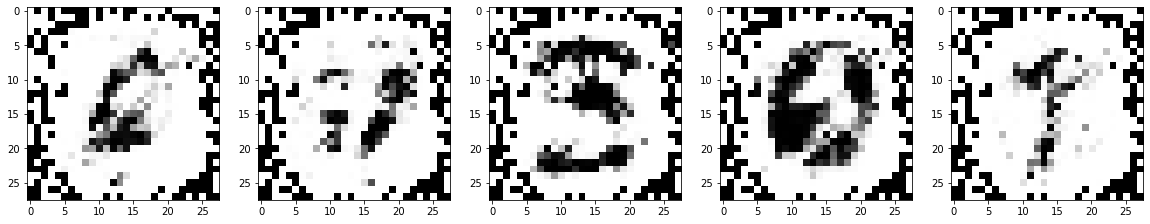

12/200 GEN_LOSS 3.3048 DISC_LOSS 0.0858(0.06)(0.11)


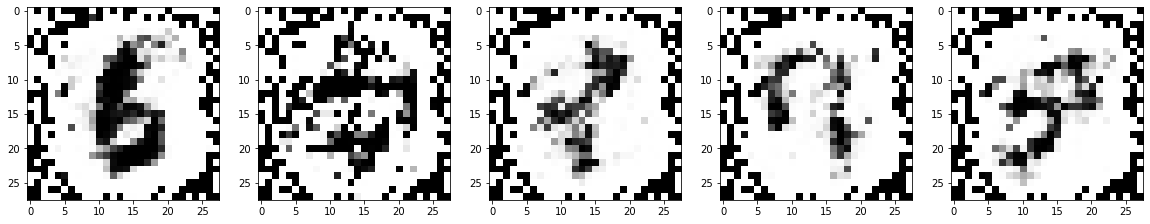

13/200 GEN_LOSS 2.4669 DISC_LOSS 0.2382(0.29)(0.19)


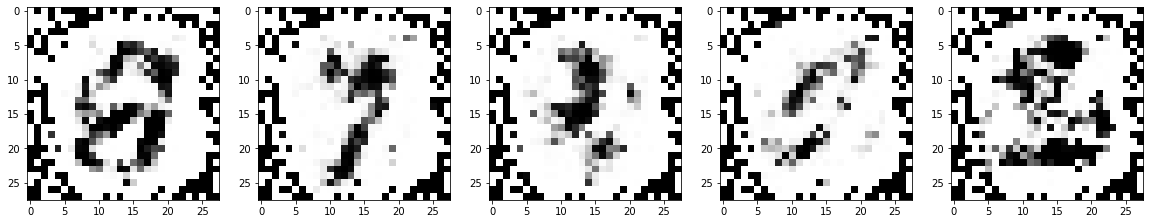

14/200 GEN_LOSS 2.7018 DISC_LOSS 0.3646(0.61)(0.12)


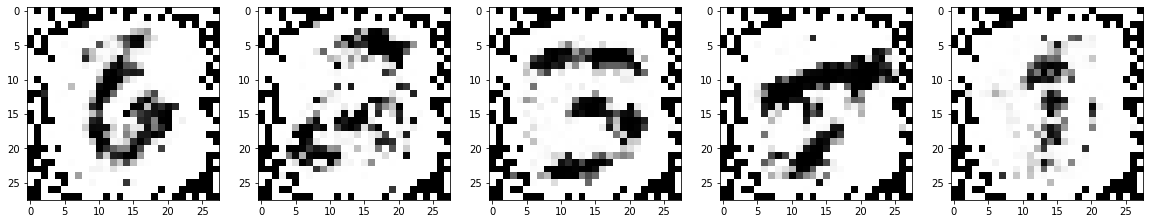

15/200 GEN_LOSS 2.5035 DISC_LOSS 0.3356(0.49)(0.18)


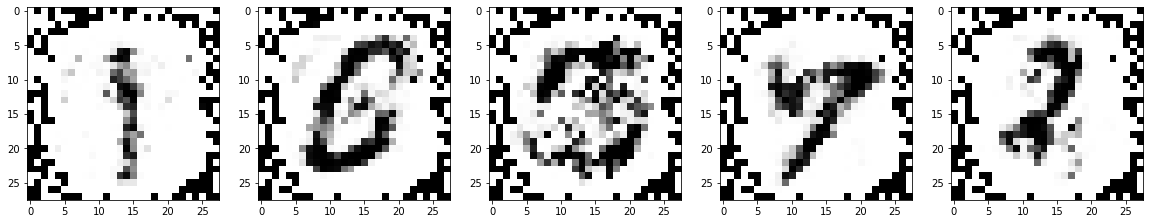

16/200 GEN_LOSS 3.9881 DISC_LOSS 0.1774(0.31)(0.04)


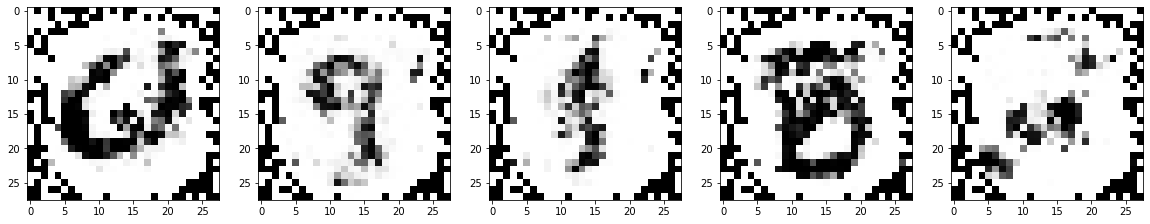

17/200 GEN_LOSS 1.1766 DISC_LOSS 0.3837(0.16)(0.61)


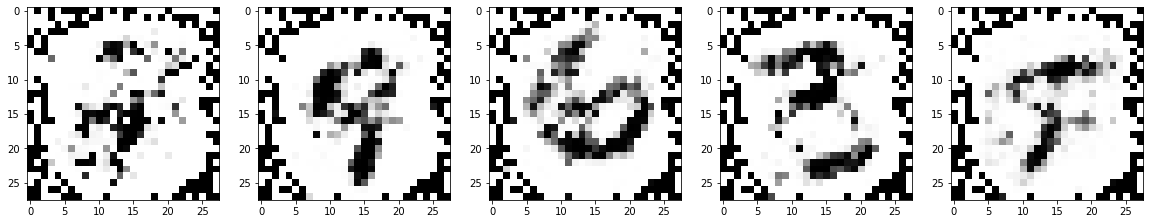

18/200 GEN_LOSS 3.7460 DISC_LOSS 0.2890(0.50)(0.08)


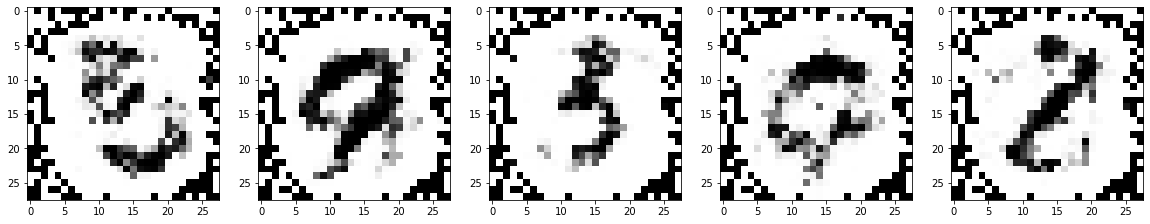

19/200 GEN_LOSS 2.0862 DISC_LOSS 0.3667(0.28)(0.45)


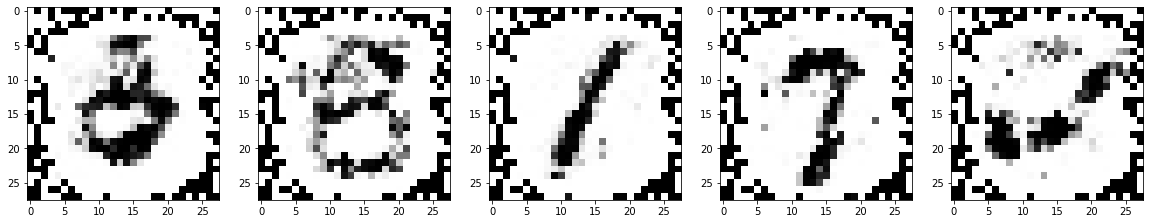

20/200 GEN_LOSS 2.6310 DISC_LOSS 0.3170(0.41)(0.22)


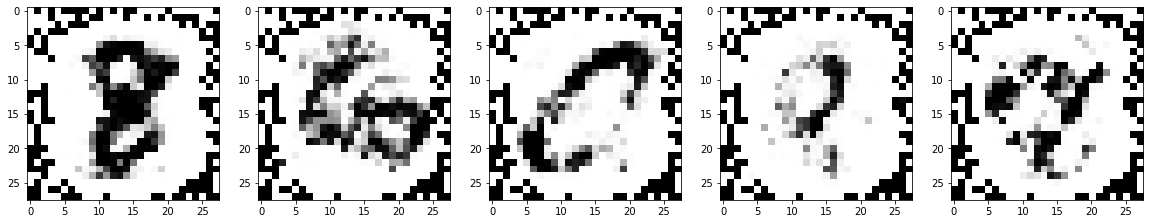

21/200 GEN_LOSS 2.7481 DISC_LOSS 0.3737(0.64)(0.11)


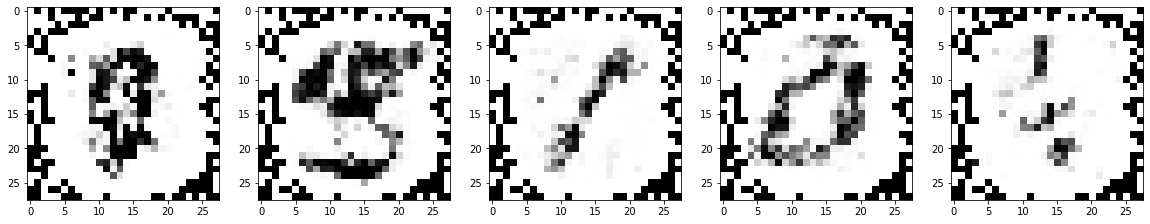

22/200 GEN_LOSS 2.0960 DISC_LOSS 0.3353(0.40)(0.27)


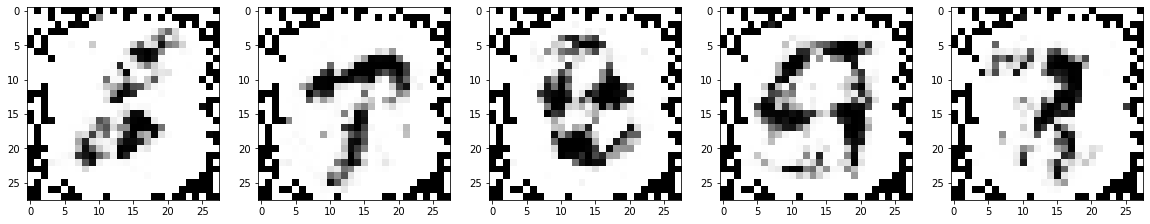

23/200 GEN_LOSS 1.5183 DISC_LOSS 0.3378(0.31)(0.37)


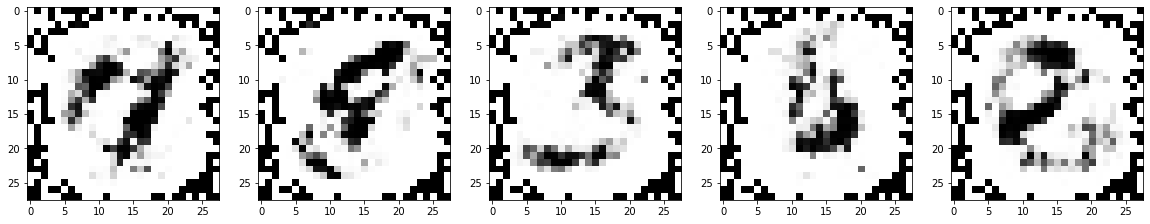

24/200 GEN_LOSS 2.3825 DISC_LOSS 0.4591(0.69)(0.23)


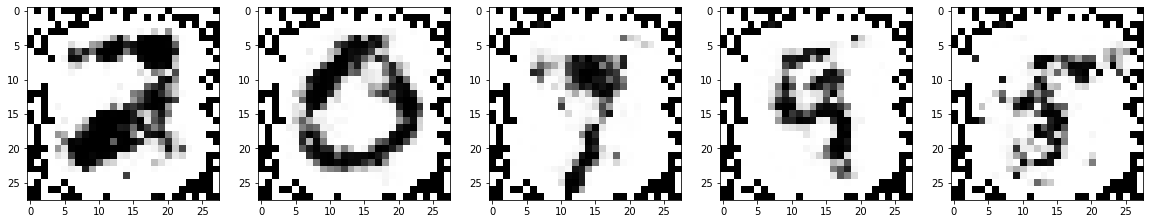

25/200 GEN_LOSS 2.6520 DISC_LOSS 0.2979(0.41)(0.18)


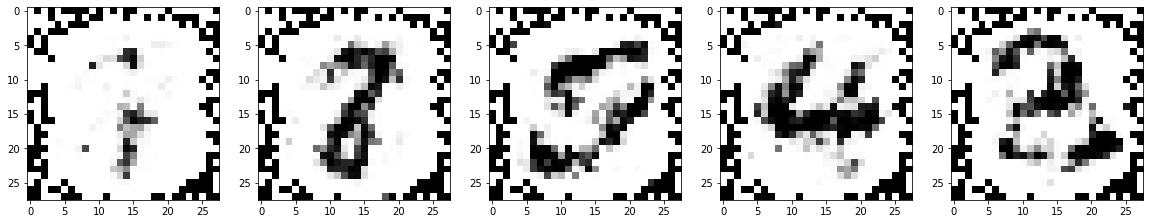

26/200 GEN_LOSS 1.6146 DISC_LOSS 1.4359(2.40)(0.47)


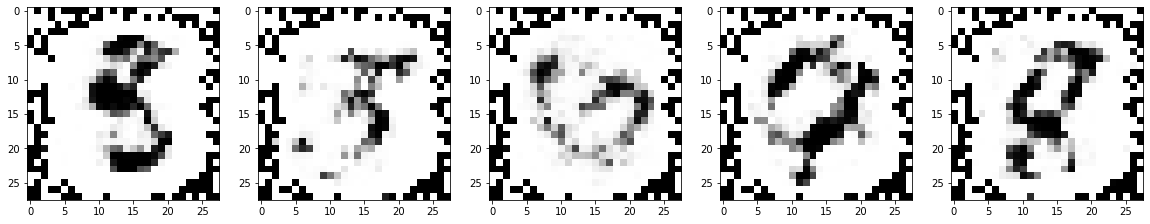

27/200 GEN_LOSS 2.3138 DISC_LOSS 1.0235(1.83)(0.22)


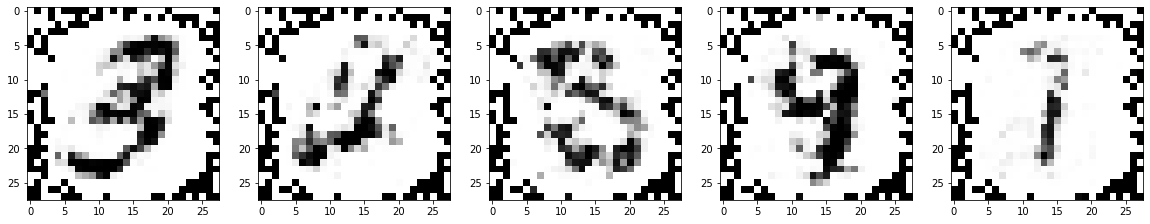

28/200 GEN_LOSS 2.2490 DISC_LOSS 0.3744(0.48)(0.27)


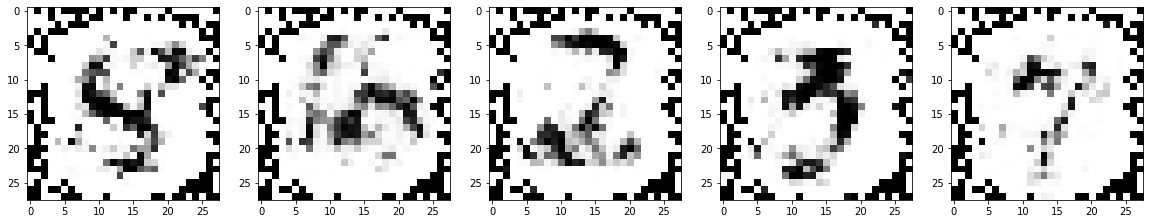

29/200 GEN_LOSS 2.1680 DISC_LOSS 0.3594(0.46)(0.26)


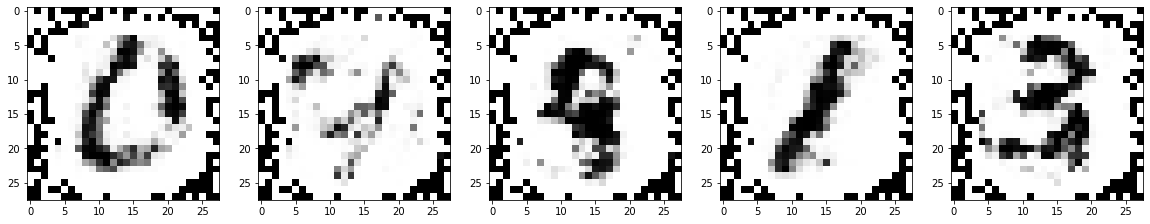

30/200 GEN_LOSS 1.0669 DISC_LOSS 0.7400(0.83)(0.65)


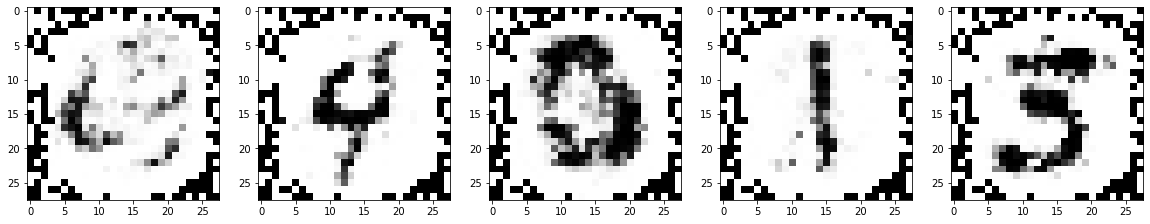

31/200 GEN_LOSS 1.4501 DISC_LOSS 0.4844(0.40)(0.57)


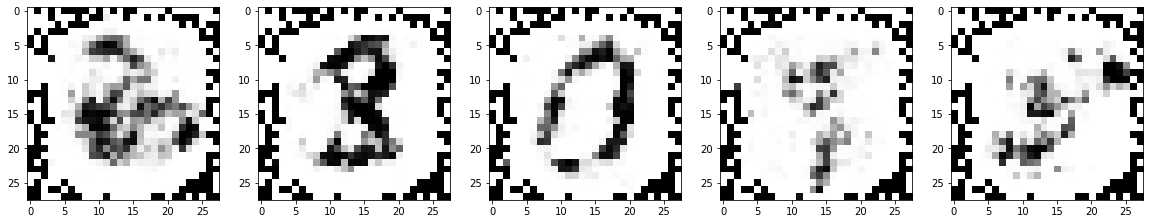

32/200 GEN_LOSS 1.7330 DISC_LOSS 0.5912(0.84)(0.35)


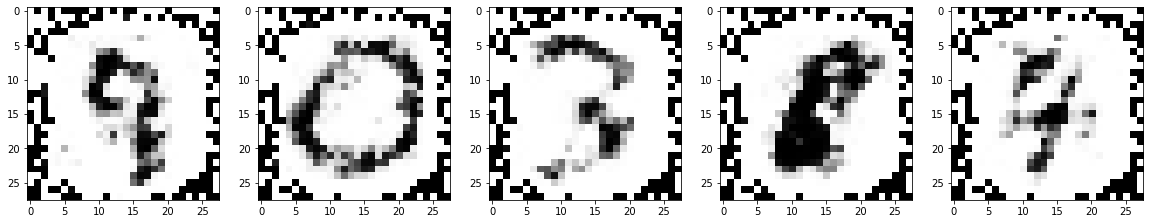

33/200 GEN_LOSS 1.6805 DISC_LOSS 0.4134(0.49)(0.34)


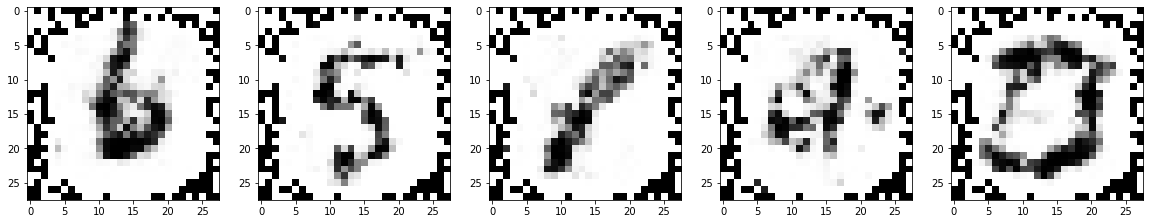

34/200 GEN_LOSS 1.6418 DISC_LOSS 0.6114(0.76)(0.46)


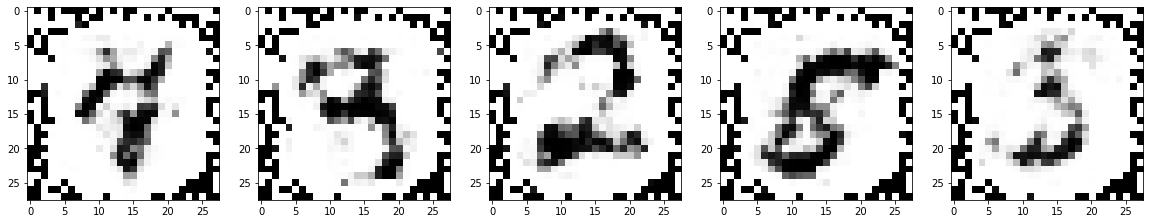

35/200 GEN_LOSS 1.6103 DISC_LOSS 0.5533(0.74)(0.37)


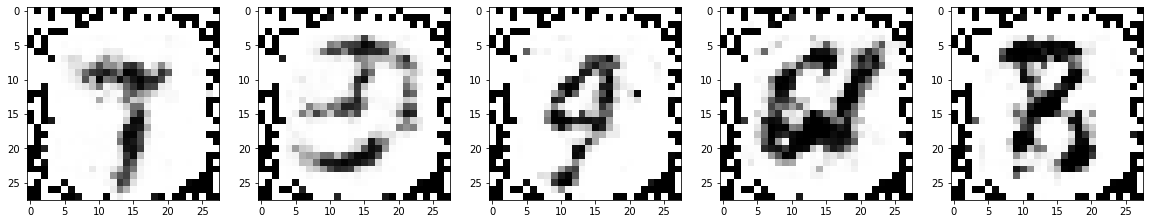

36/200 GEN_LOSS 1.1705 DISC_LOSS 0.4951(0.37)(0.62)


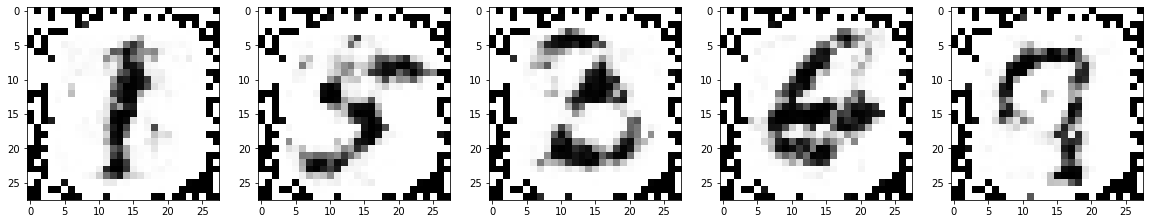

37/200 GEN_LOSS 1.3431 DISC_LOSS 0.5158(0.60)(0.43)


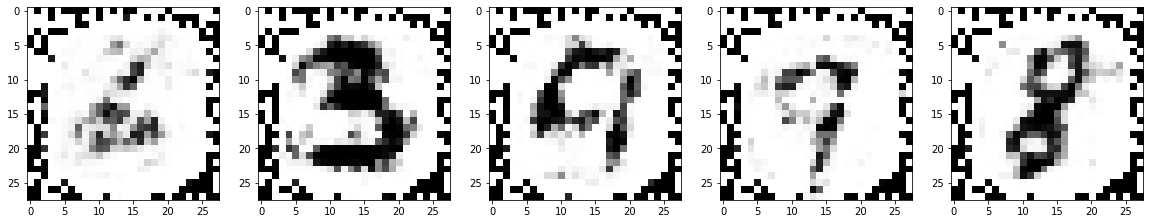

38/200 GEN_LOSS 1.7423 DISC_LOSS 0.4470(0.62)(0.28)


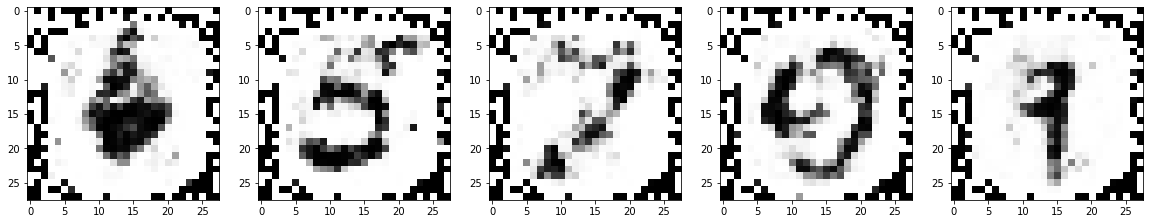

39/200 GEN_LOSS 2.0504 DISC_LOSS 0.4179(0.55)(0.29)


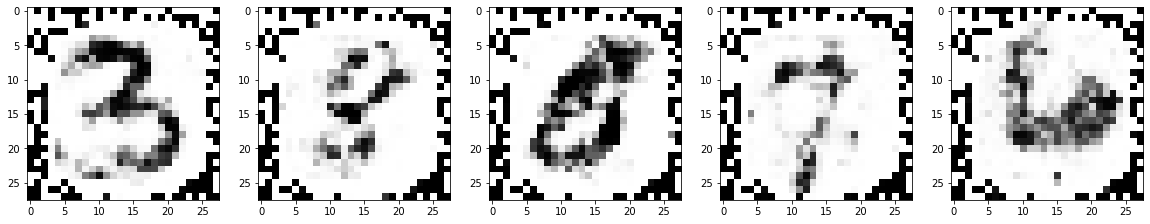

40/200 GEN_LOSS 1.4699 DISC_LOSS 0.5871(0.79)(0.39)


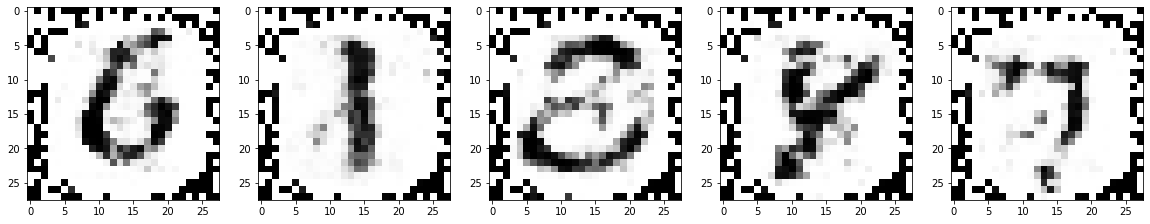

41/200 GEN_LOSS 1.3924 DISC_LOSS 0.3826(0.27)(0.50)


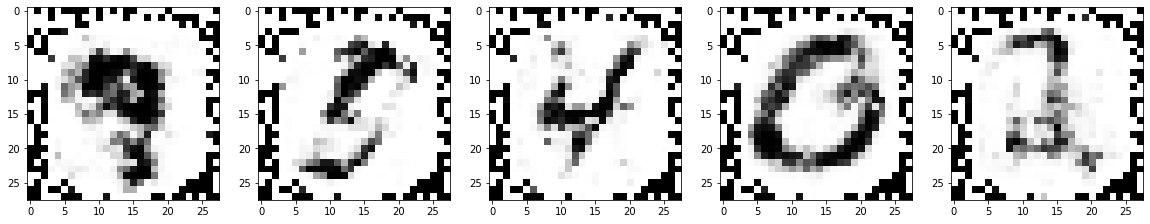

42/200 GEN_LOSS 1.6932 DISC_LOSS 0.4059(0.42)(0.39)


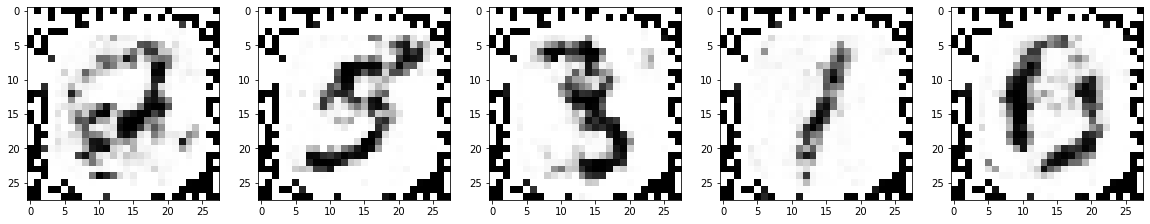

43/200 GEN_LOSS 1.3223 DISC_LOSS 0.5401(0.58)(0.50)


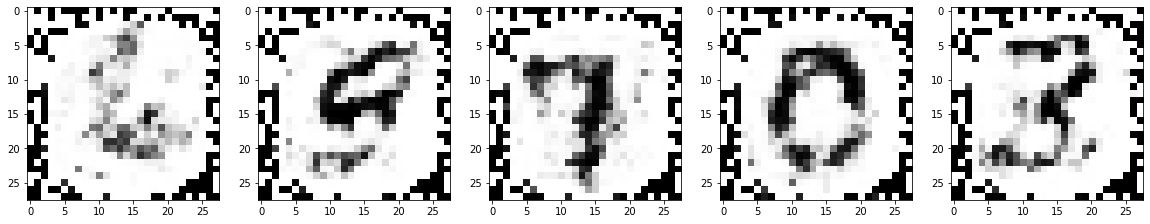

44/200 GEN_LOSS 1.5637 DISC_LOSS 0.4823(0.52)(0.44)


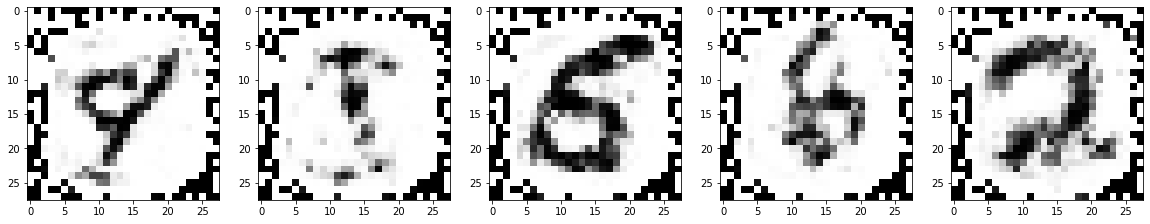

45/200 GEN_LOSS 1.2347 DISC_LOSS 0.5656(0.64)(0.50)


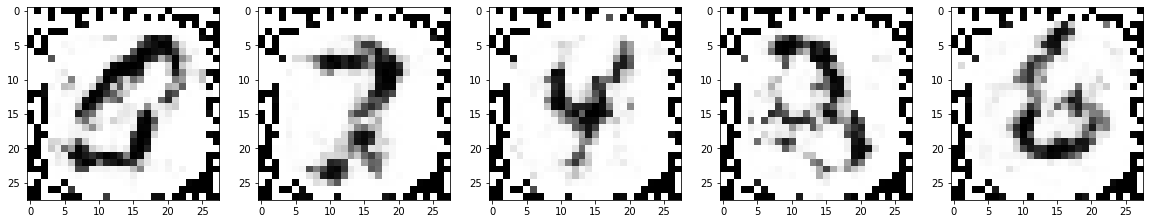

46/200 GEN_LOSS 1.1514 DISC_LOSS 0.5268(0.54)(0.51)


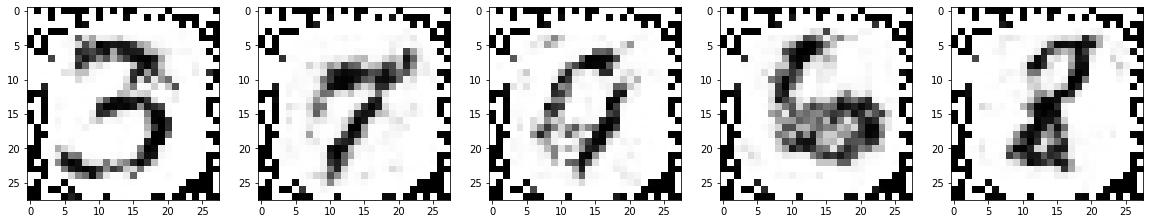

47/200 GEN_LOSS 1.7266 DISC_LOSS 0.6719(0.77)(0.57)


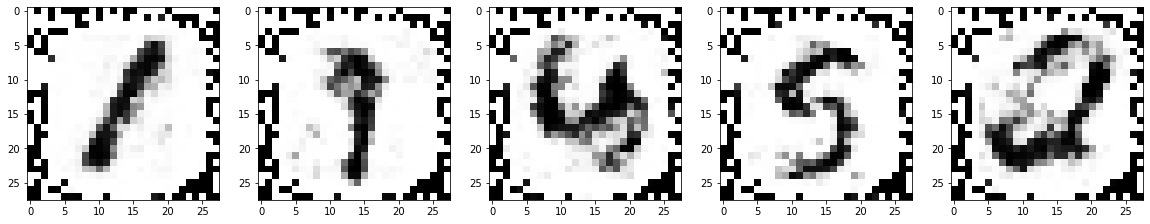

48/200 GEN_LOSS 1.2206 DISC_LOSS 0.7602(0.75)(0.77)


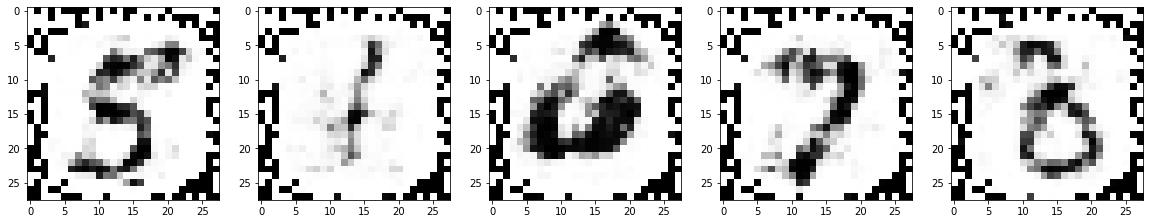

49/200 GEN_LOSS 1.6766 DISC_LOSS 0.6130(0.85)(0.38)


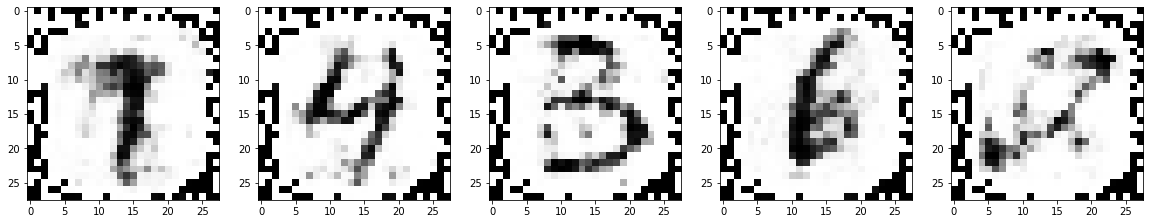

50/200 GEN_LOSS 0.9843 DISC_LOSS 0.8437(0.45)(1.24)


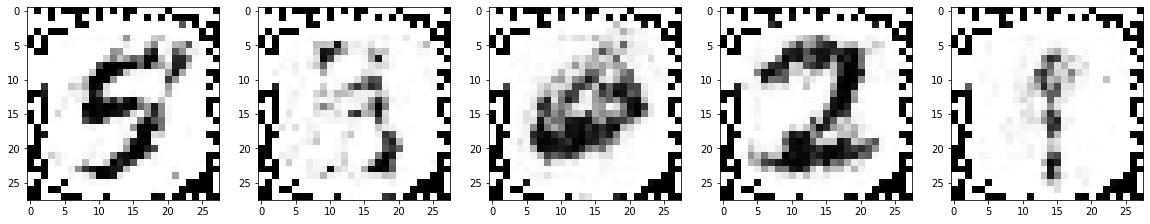

51/200 GEN_LOSS 1.2367 DISC_LOSS 0.6142(0.73)(0.50)


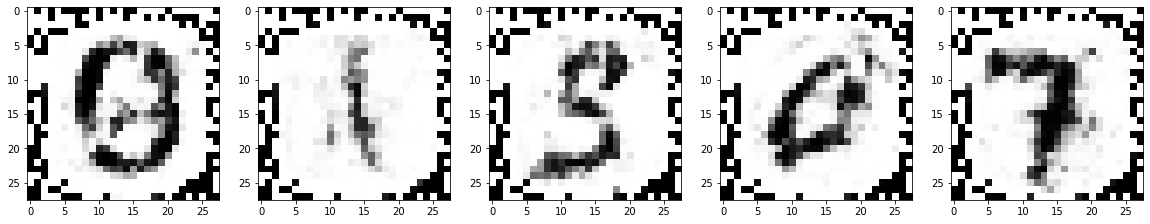

52/200 GEN_LOSS 1.5848 DISC_LOSS 0.5839(0.75)(0.41)


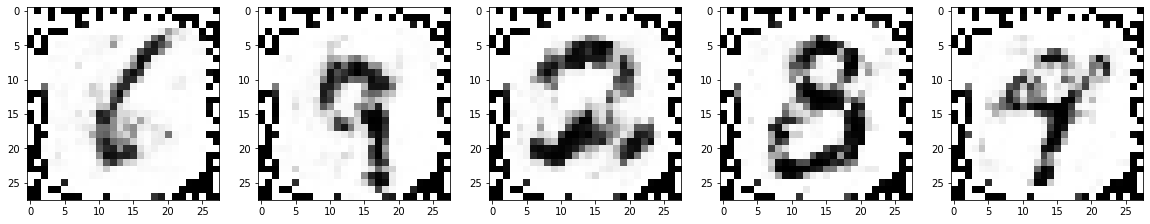

53/200 GEN_LOSS 1.8491 DISC_LOSS 0.5572(0.78)(0.34)


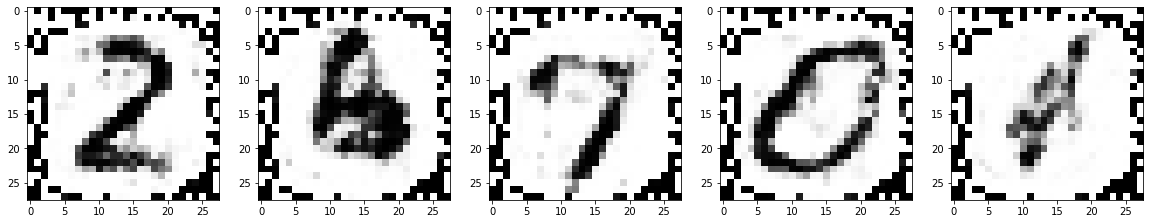

54/200 GEN_LOSS 1.3048 DISC_LOSS 0.4329(0.36)(0.51)


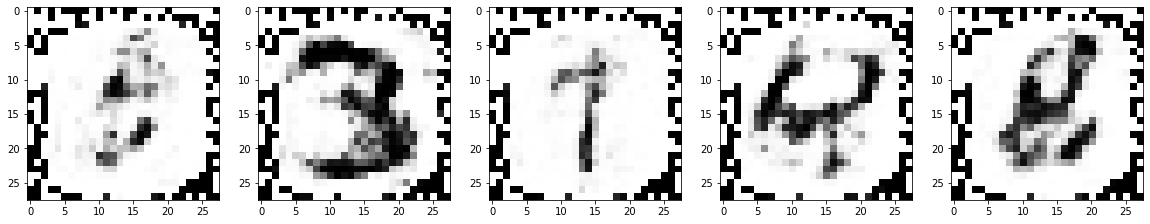

55/200 GEN_LOSS 1.2874 DISC_LOSS 0.6771(0.86)(0.49)


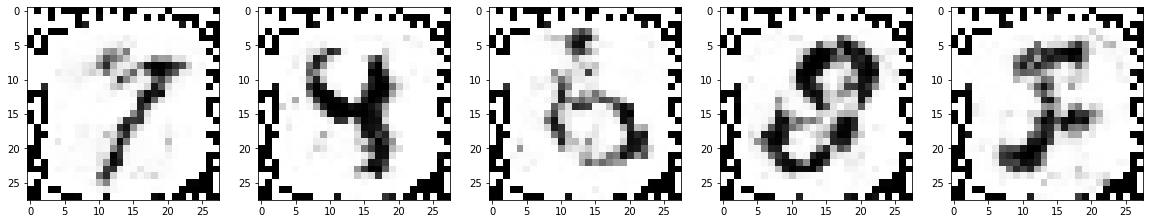

56/200 GEN_LOSS 1.4053 DISC_LOSS 0.6440(0.79)(0.49)


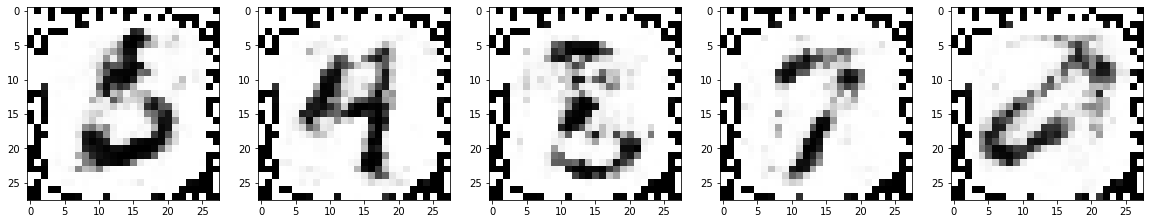

57/200 GEN_LOSS 1.4801 DISC_LOSS 0.5701(0.71)(0.43)


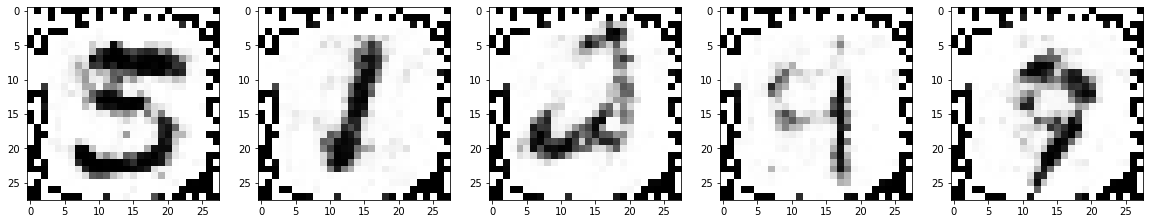

58/200 GEN_LOSS 1.0208 DISC_LOSS 0.7648(0.80)(0.73)


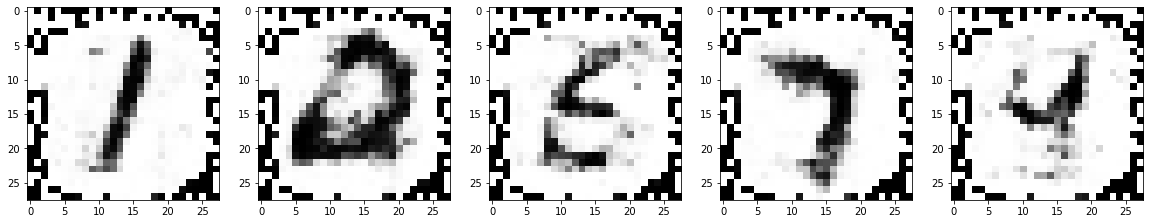

59/200 GEN_LOSS 0.9875 DISC_LOSS 0.6773(0.74)(0.62)


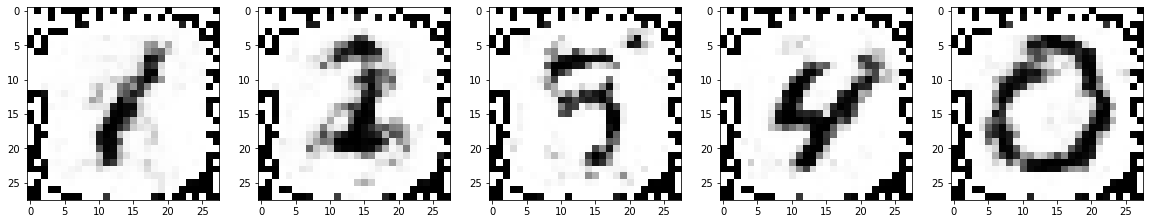

60/200 GEN_LOSS 1.1500 DISC_LOSS 0.7383(0.93)(0.55)


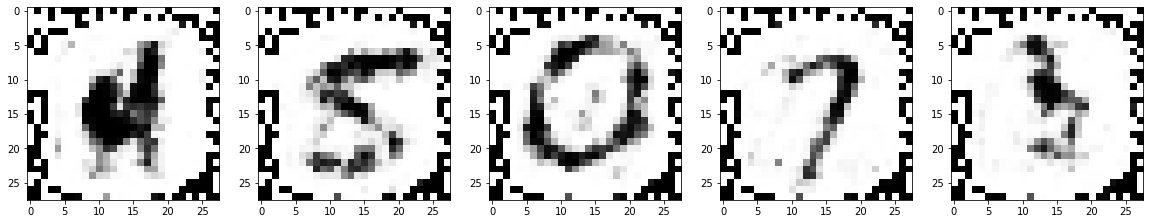

61/200 GEN_LOSS 2.2349 DISC_LOSS 0.3402(0.42)(0.26)


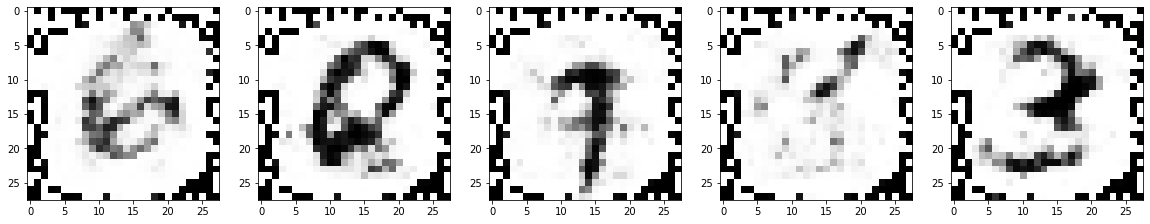

62/200 GEN_LOSS 1.5037 DISC_LOSS 0.5667(0.76)(0.37)


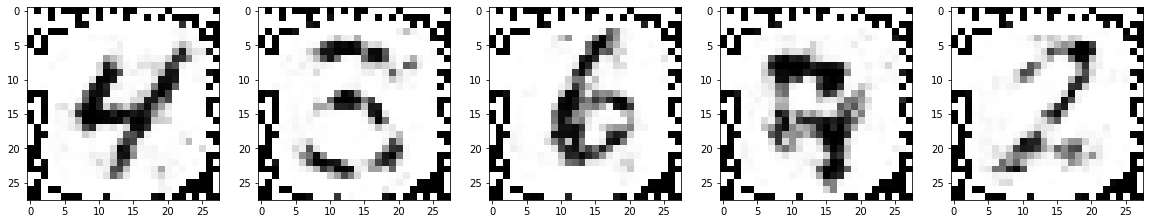

63/200 GEN_LOSS 1.2009 DISC_LOSS 0.6189(0.70)(0.54)


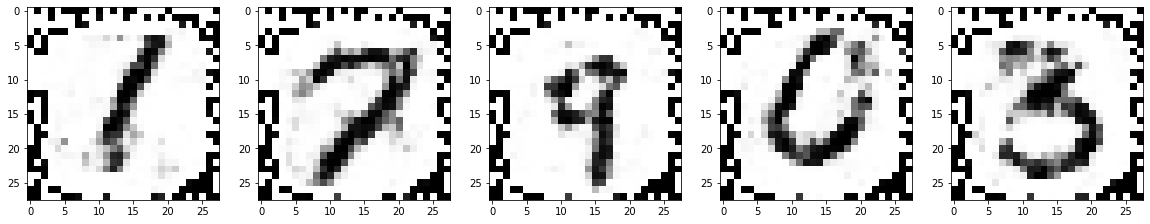

64/200 GEN_LOSS 1.0469 DISC_LOSS 0.7101(0.85)(0.57)


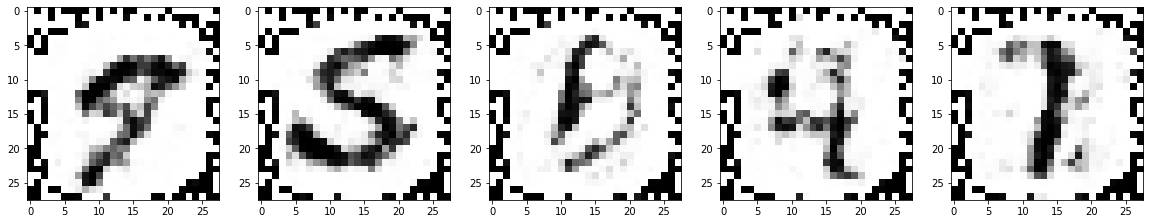

65/200 GEN_LOSS 1.2948 DISC_LOSS 0.7223(0.89)(0.55)


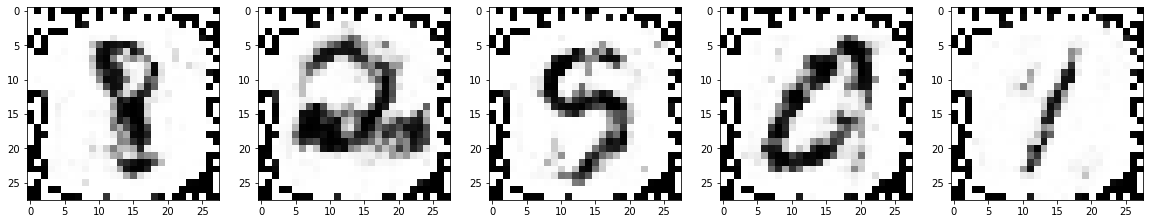

66/200 GEN_LOSS 1.1861 DISC_LOSS 0.5999(0.65)(0.55)


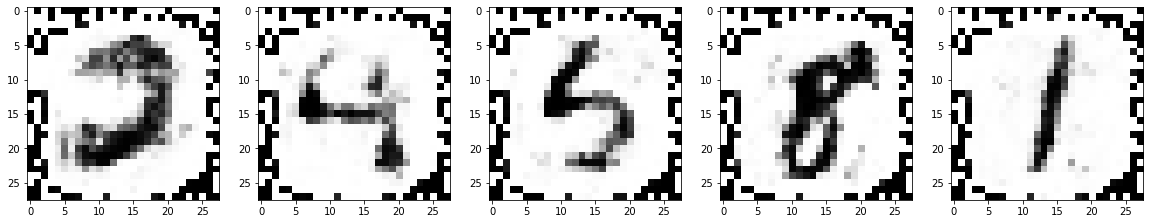

67/200 GEN_LOSS 1.7973 DISC_LOSS 0.4204(0.49)(0.36)


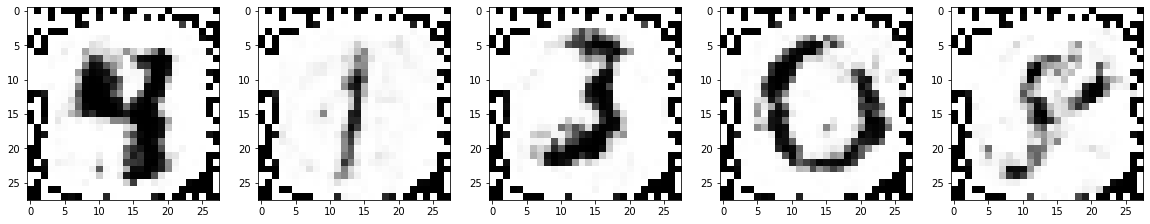

68/200 GEN_LOSS 1.2826 DISC_LOSS 0.7973(1.15)(0.44)


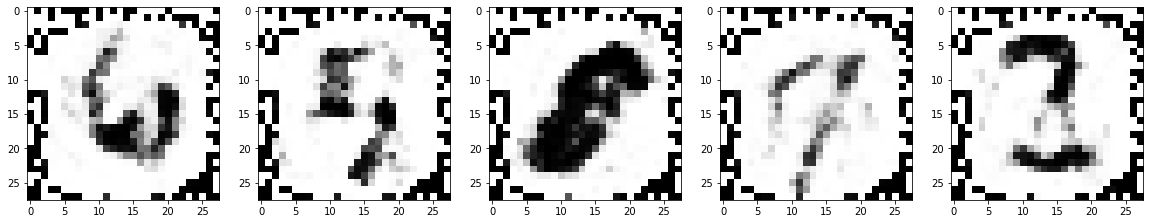

69/200 GEN_LOSS 1.7205 DISC_LOSS 0.7491(1.19)(0.31)


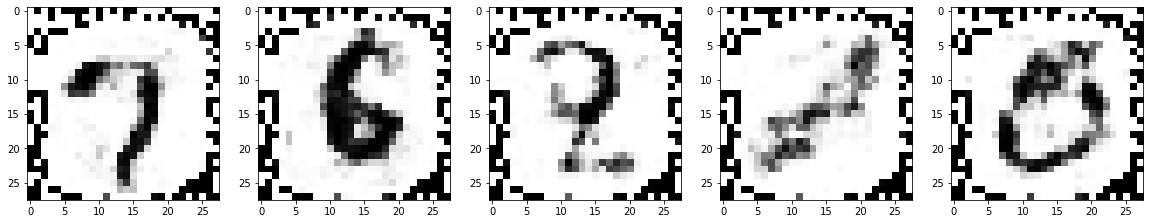

70/200 GEN_LOSS 1.1104 DISC_LOSS 0.7528(0.98)(0.53)


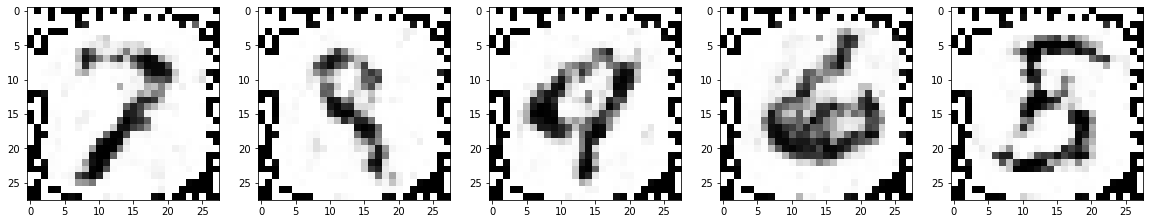

71/200 GEN_LOSS 1.3326 DISC_LOSS 0.4419(0.47)(0.42)


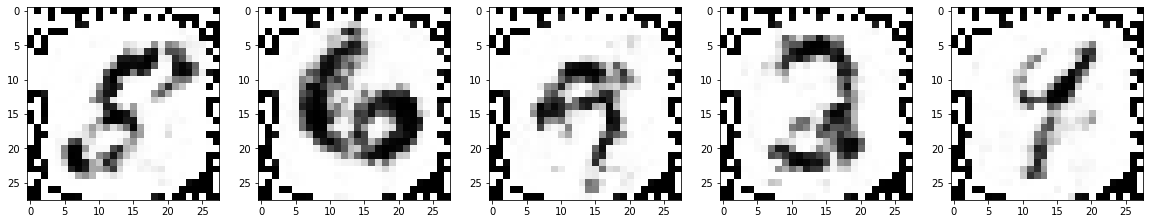

72/200 GEN_LOSS 1.1629 DISC_LOSS 0.7143(0.86)(0.57)


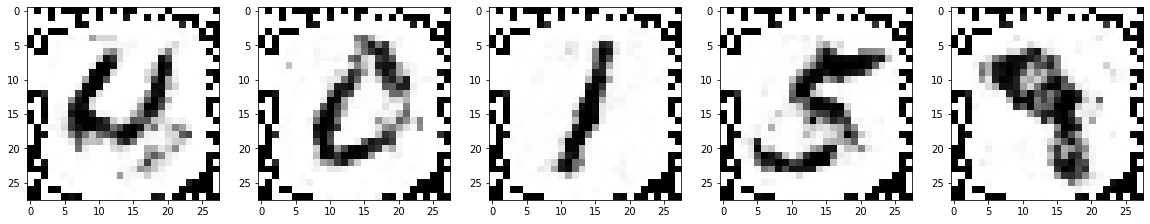

73/200 GEN_LOSS 1.1556 DISC_LOSS 0.5443(0.46)(0.62)


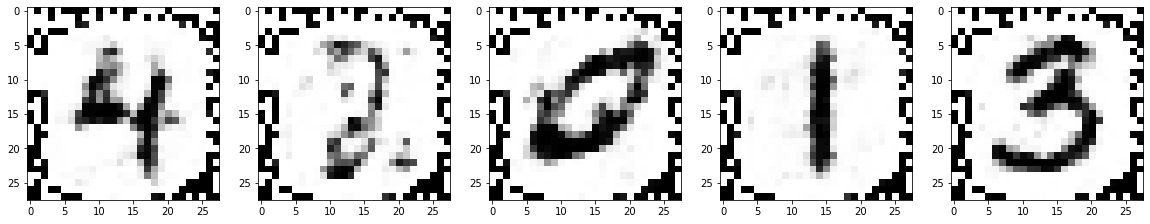

74/200 GEN_LOSS 1.3513 DISC_LOSS 0.6322(0.88)(0.38)


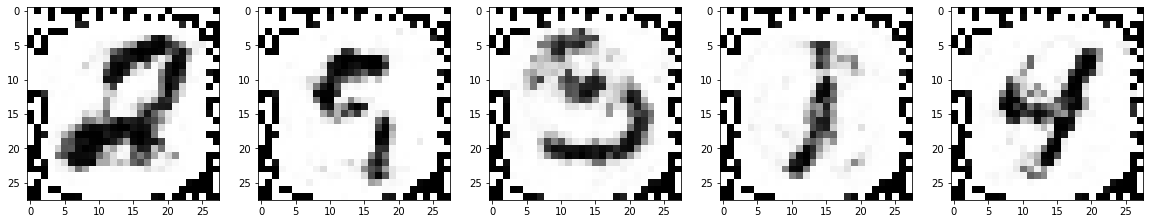

75/200 GEN_LOSS 1.2569 DISC_LOSS 0.6492(0.84)(0.46)


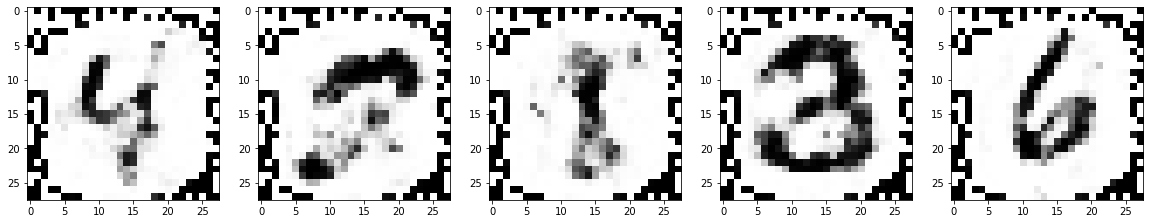

76/200 GEN_LOSS 1.5542 DISC_LOSS 0.5594(0.58)(0.54)


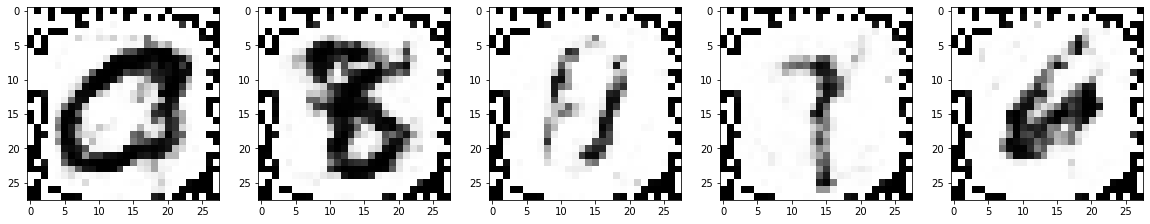

77/200 GEN_LOSS 1.3104 DISC_LOSS 0.5188(0.60)(0.44)


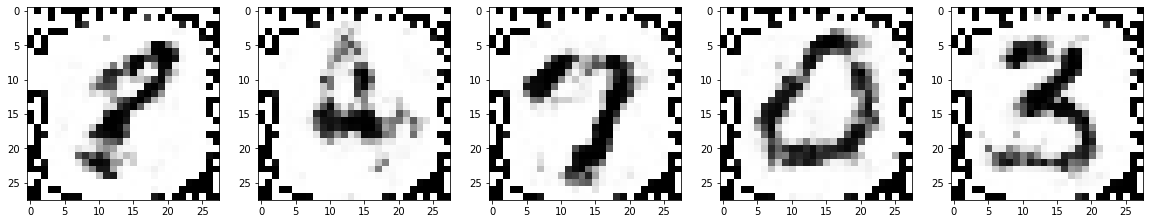

78/200 GEN_LOSS 1.3147 DISC_LOSS 0.6336(0.66)(0.60)


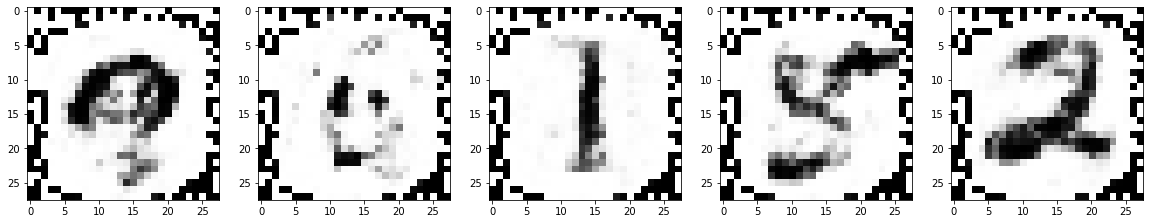

79/200 GEN_LOSS 1.3376 DISC_LOSS 0.5286(0.59)(0.47)


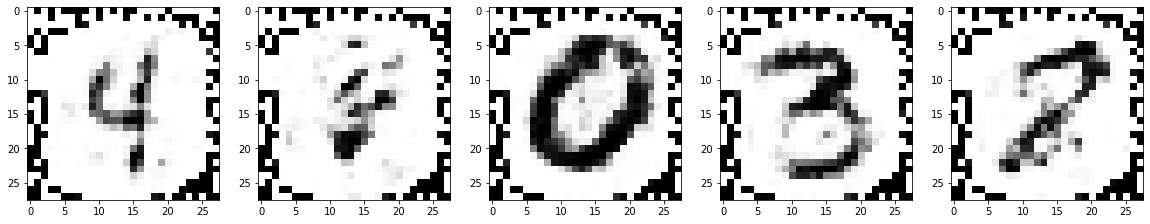

80/200 GEN_LOSS 1.0538 DISC_LOSS 0.6711(0.75)(0.59)


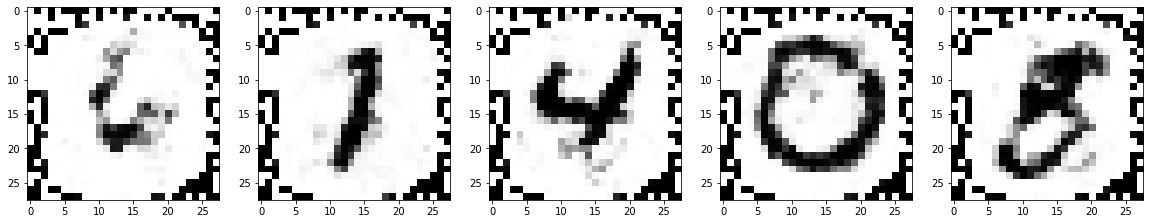

81/200 GEN_LOSS 1.1179 DISC_LOSS 1.0967(1.56)(0.63)


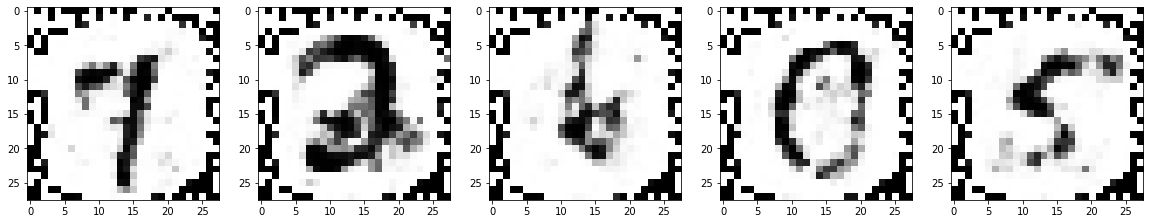

82/200 GEN_LOSS 1.3525 DISC_LOSS 0.4290(0.35)(0.51)


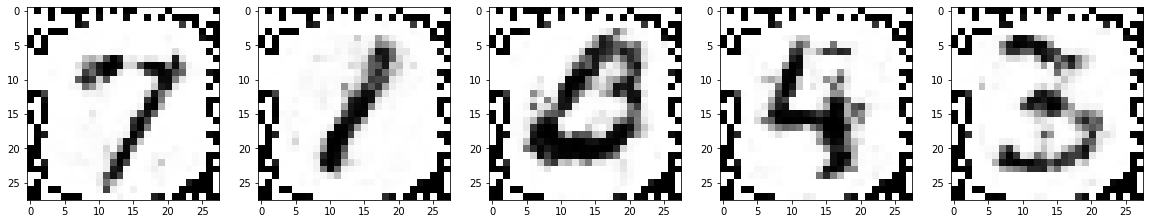

83/200 GEN_LOSS 0.8134 DISC_LOSS 0.8291(0.83)(0.83)


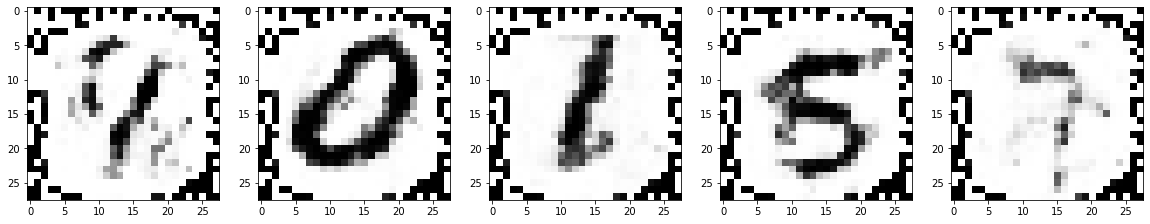

84/200 GEN_LOSS 2.0171 DISC_LOSS 0.5586(0.81)(0.31)


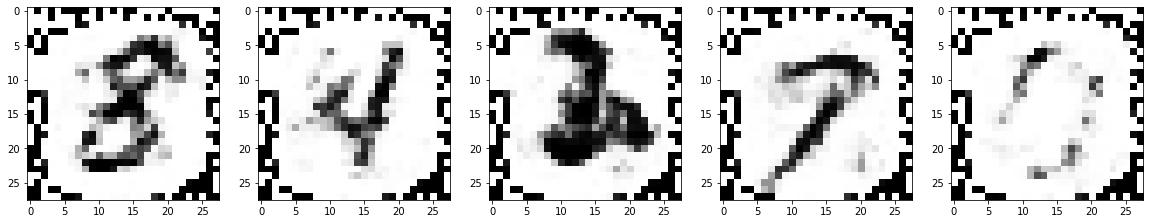

85/200 GEN_LOSS 2.0243 DISC_LOSS 0.2100(0.20)(0.22)


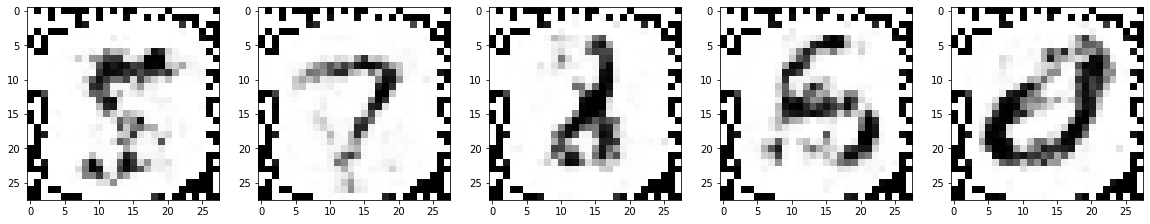

86/200 GEN_LOSS 1.6323 DISC_LOSS 0.2301(0.12)(0.34)


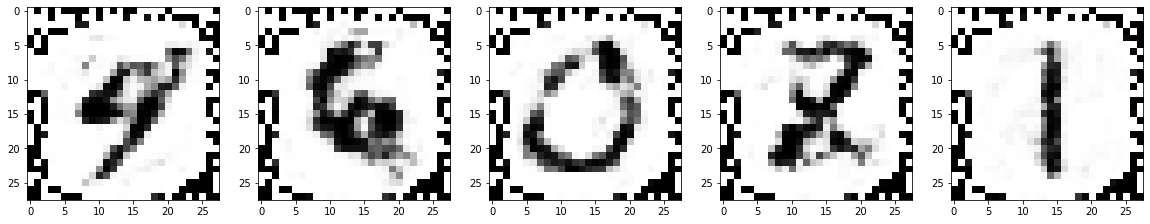

87/200 GEN_LOSS 1.8396 DISC_LOSS 0.6425(1.00)(0.28)


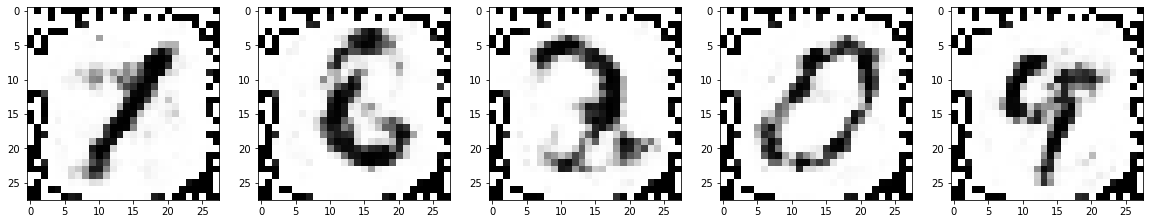

88/200 GEN_LOSS 1.1448 DISC_LOSS 0.6839(0.85)(0.52)


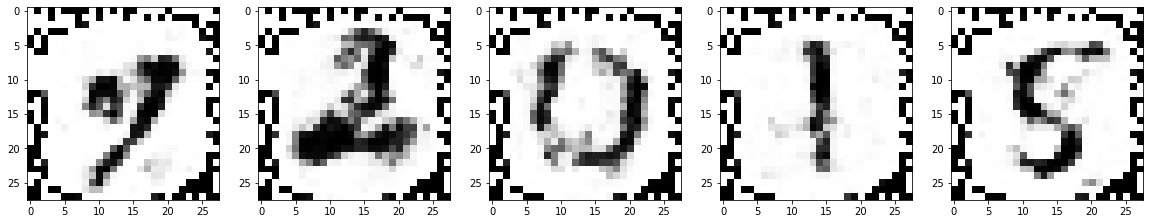

89/200 GEN_LOSS 1.5943 DISC_LOSS 0.5395(0.69)(0.39)


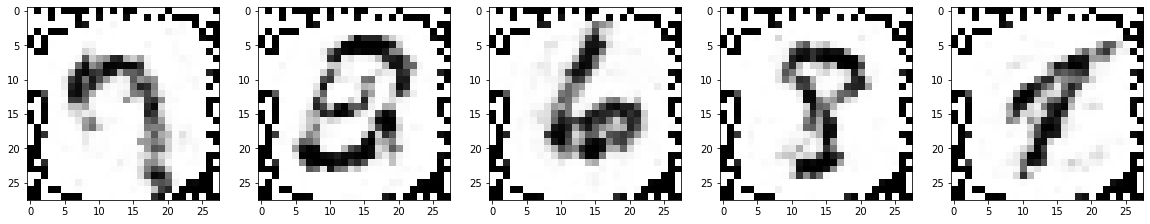

90/200 GEN_LOSS 1.8142 DISC_LOSS 0.5681(0.82)(0.32)


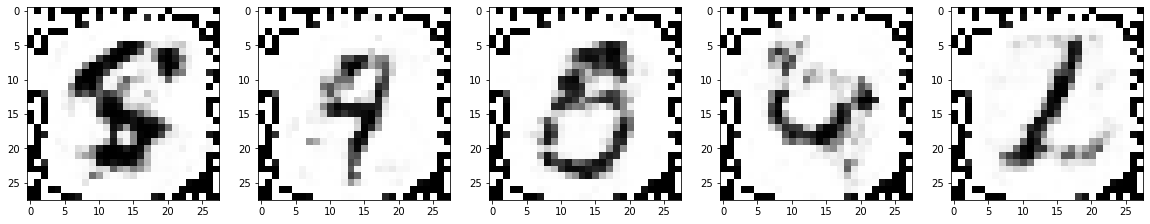

91/200 GEN_LOSS 1.3408 DISC_LOSS 0.6501(0.80)(0.50)


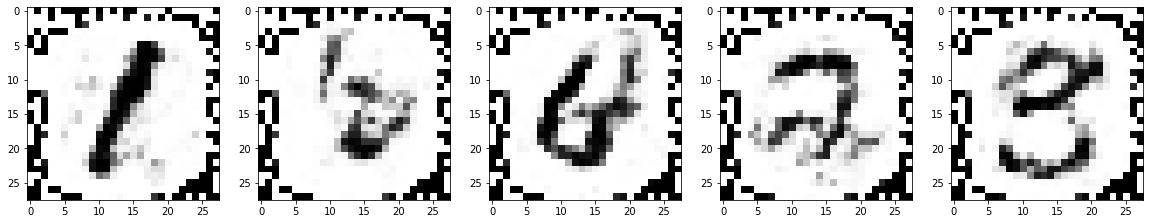

92/200 GEN_LOSS 1.5102 DISC_LOSS 0.7578(1.11)(0.40)


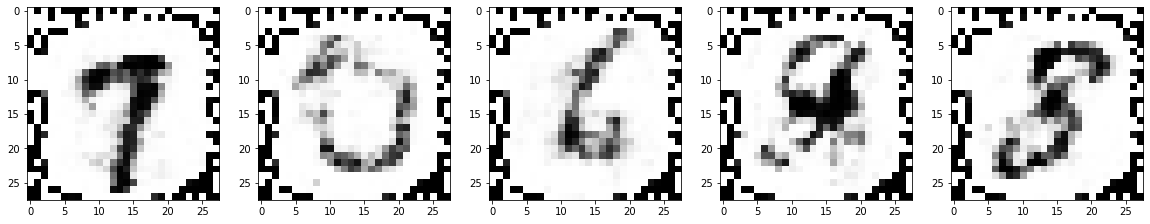

93/200 GEN_LOSS 1.7585 DISC_LOSS 0.3927(0.54)(0.25)


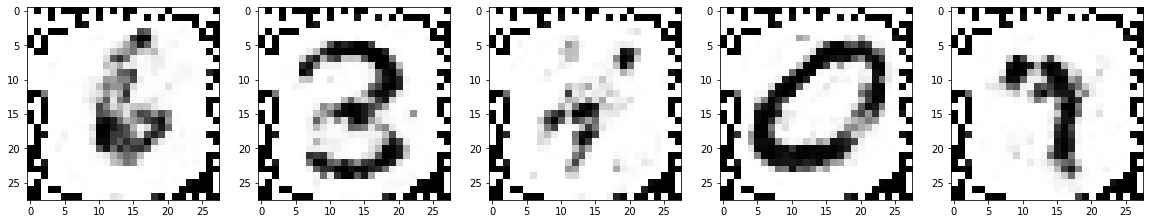

94/200 GEN_LOSS 1.3740 DISC_LOSS 0.5325(0.58)(0.49)


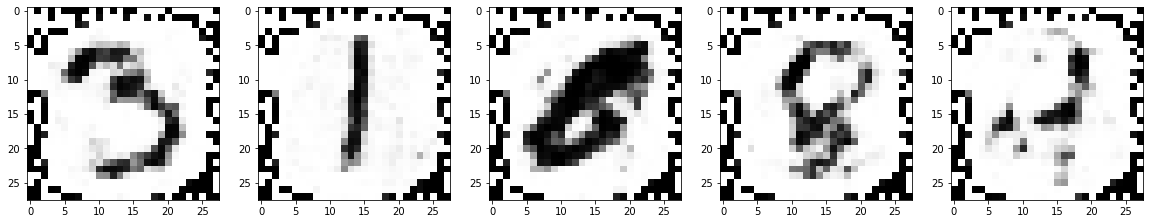

95/200 GEN_LOSS 1.7540 DISC_LOSS 0.4110(0.52)(0.30)


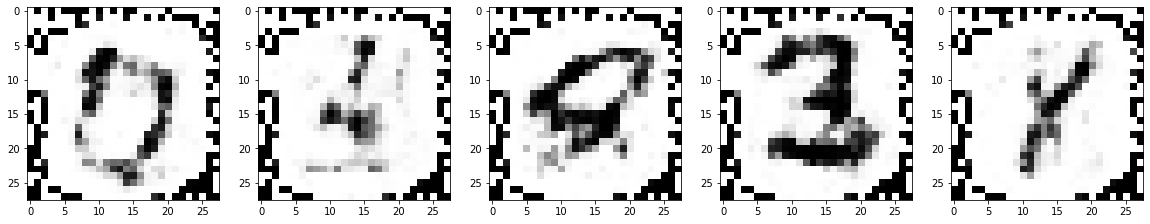

96/200 GEN_LOSS 1.3861 DISC_LOSS 0.4329(0.47)(0.39)


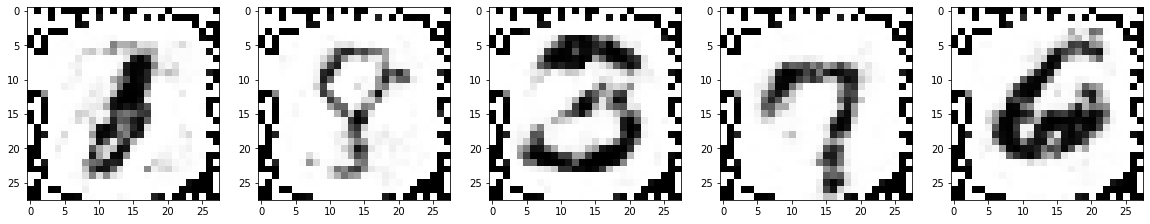

97/200 GEN_LOSS 1.5820 DISC_LOSS 0.5034(0.63)(0.38)


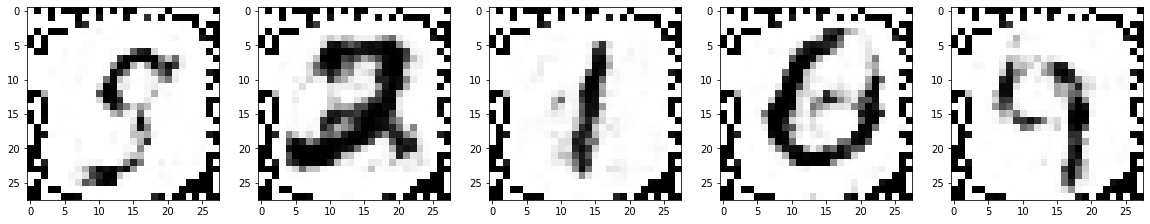

98/200 GEN_LOSS 1.3852 DISC_LOSS 0.5229(0.61)(0.43)


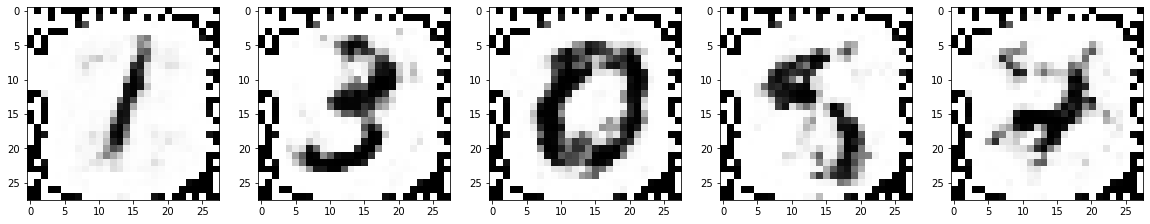

99/200 GEN_LOSS 1.5813 DISC_LOSS 0.5738(0.77)(0.37)


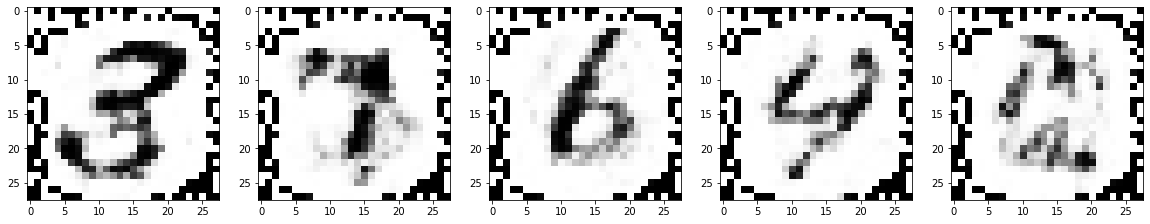

100/200 GEN_LOSS 1.7781 DISC_LOSS 0.5741(0.84)(0.31)


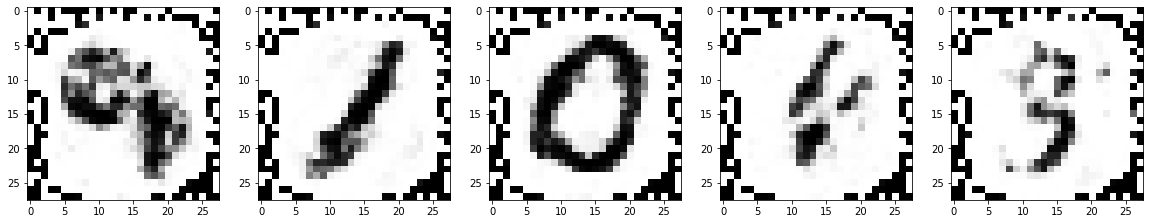

101/200 GEN_LOSS 1.4728 DISC_LOSS 0.7322(0.99)(0.47)


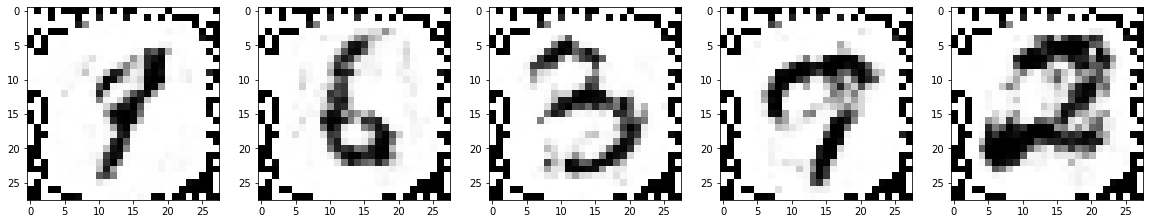

102/200 GEN_LOSS 1.6169 DISC_LOSS 0.7370(1.03)(0.44)


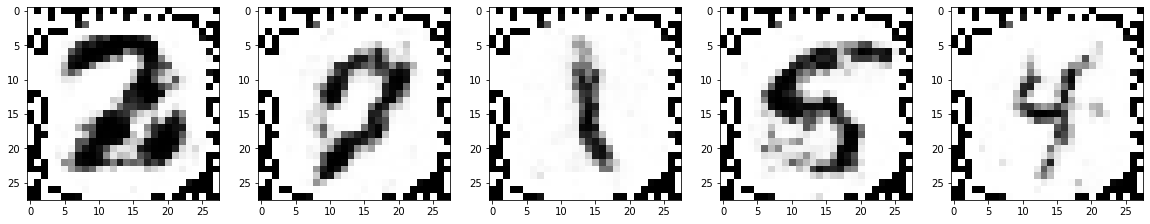

103/200 GEN_LOSS 1.5593 DISC_LOSS 0.7886(1.21)(0.37)


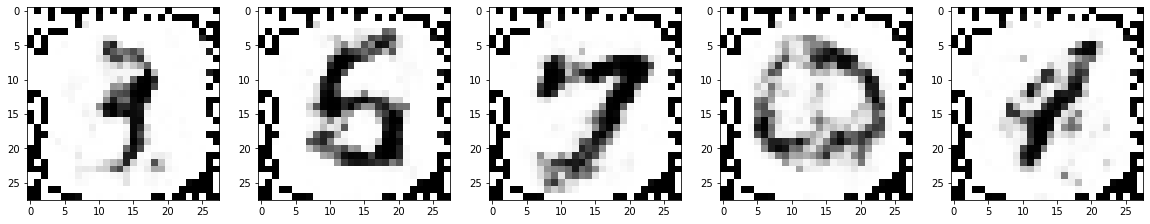

104/200 GEN_LOSS 0.9974 DISC_LOSS 0.3620(0.13)(0.59)


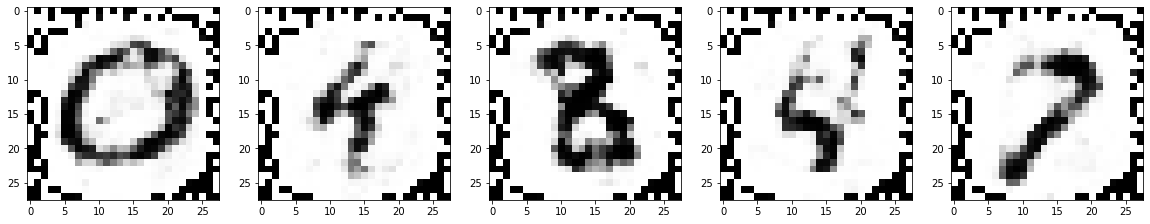

105/200 GEN_LOSS 1.4533 DISC_LOSS 0.9345(0.96)(0.91)


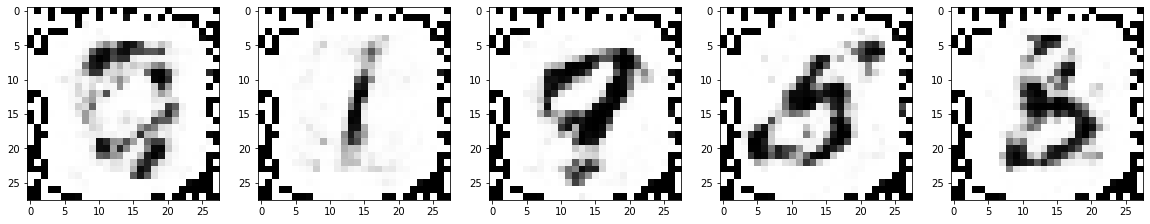

106/200 GEN_LOSS 1.2560 DISC_LOSS 1.2296(0.93)(1.53)


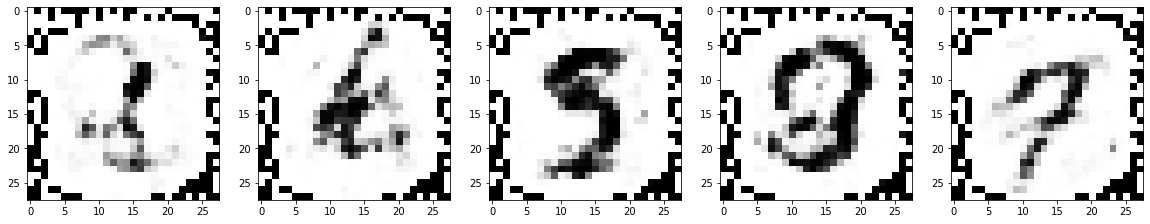

107/200 GEN_LOSS 1.4067 DISC_LOSS 0.6316(0.86)(0.40)


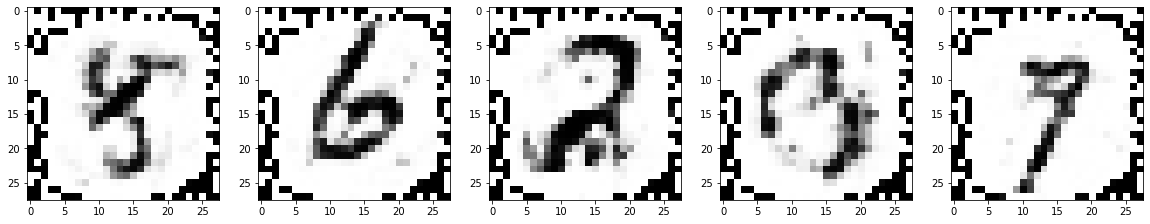

108/200 GEN_LOSS 1.7560 DISC_LOSS 0.1547(0.01)(0.29)


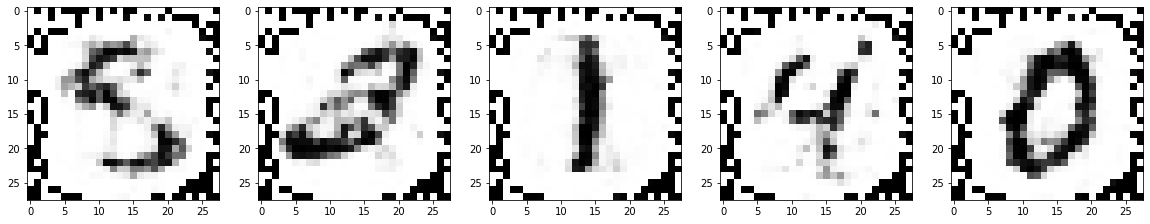

109/200 GEN_LOSS 1.7772 DISC_LOSS 0.5946(0.83)(0.35)


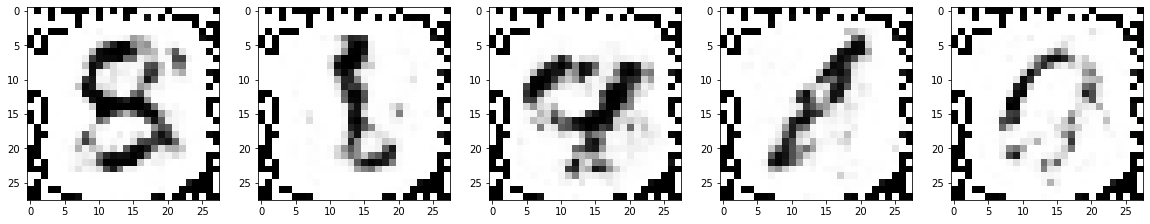

110/200 GEN_LOSS 1.5448 DISC_LOSS 0.4902(0.57)(0.41)


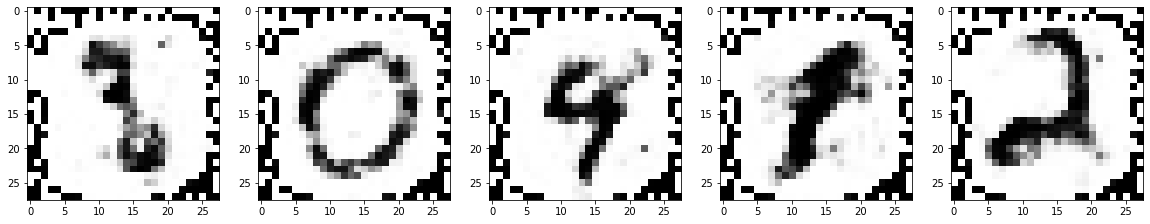

111/200 GEN_LOSS 1.9407 DISC_LOSS 0.4786(0.68)(0.28)


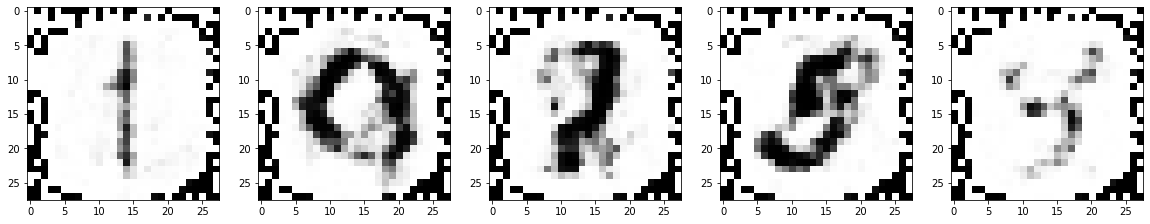

112/200 GEN_LOSS 1.7213 DISC_LOSS 0.7090(0.94)(0.48)


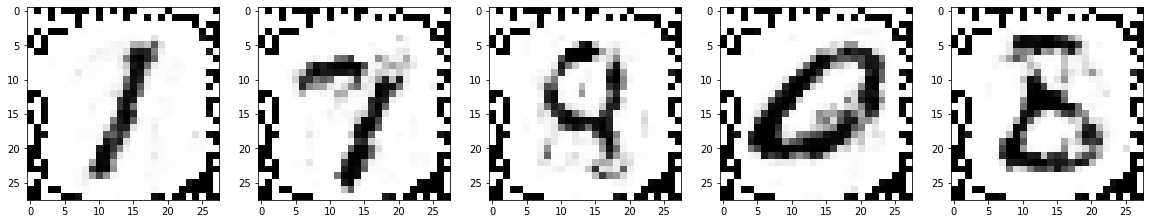

113/200 GEN_LOSS 1.3512 DISC_LOSS 0.6832(0.83)(0.54)


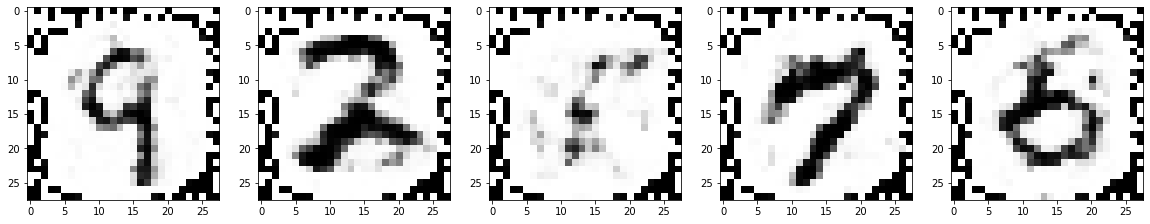

114/200 GEN_LOSS 1.6788 DISC_LOSS 0.4925(0.63)(0.35)


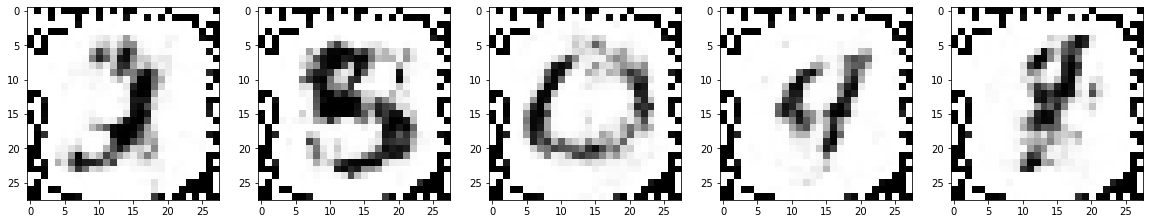

115/200 GEN_LOSS 1.7529 DISC_LOSS 0.5273(0.65)(0.40)


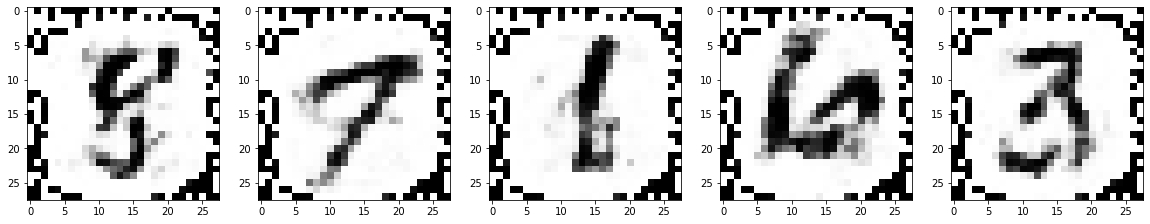

116/200 GEN_LOSS 2.0162 DISC_LOSS 0.5767(0.91)(0.24)


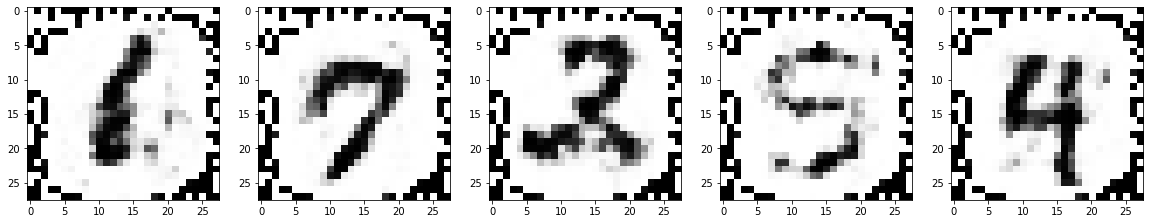

117/200 GEN_LOSS 1.2422 DISC_LOSS 0.6569(0.83)(0.48)


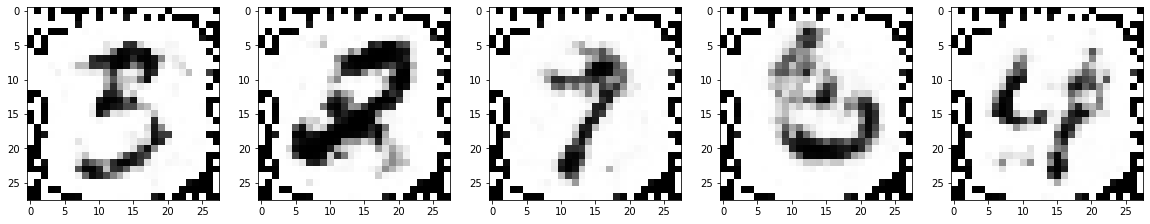

118/200 GEN_LOSS 1.6771 DISC_LOSS 0.8416(1.32)(0.37)


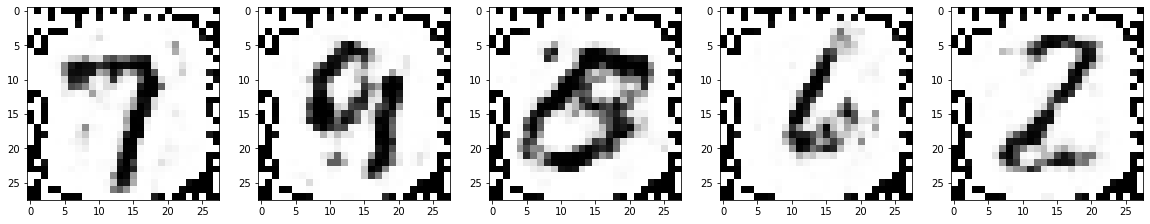

119/200 GEN_LOSS 1.1564 DISC_LOSS 0.4373(0.39)(0.49)


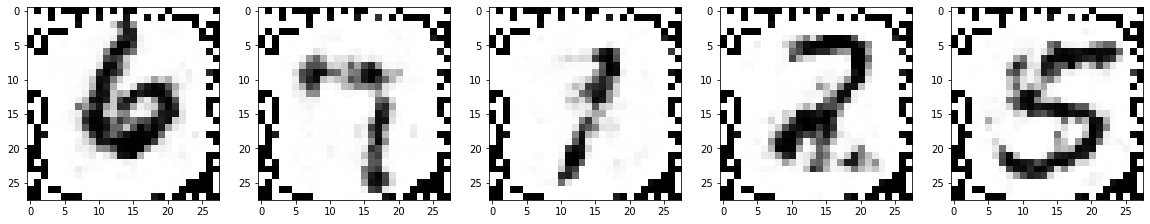

120/200 GEN_LOSS 1.1194 DISC_LOSS 0.7742(0.85)(0.70)


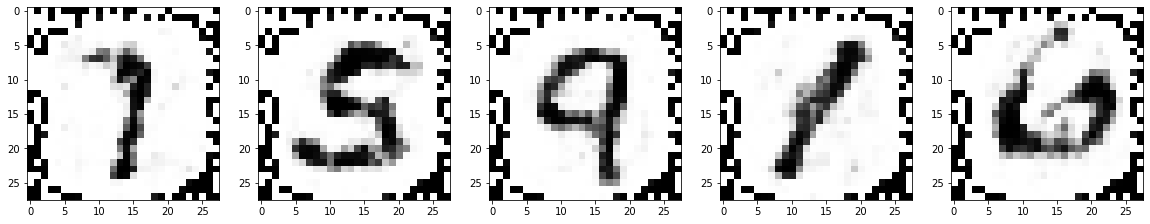

121/200 GEN_LOSS 1.4826 DISC_LOSS 0.6028(0.70)(0.50)


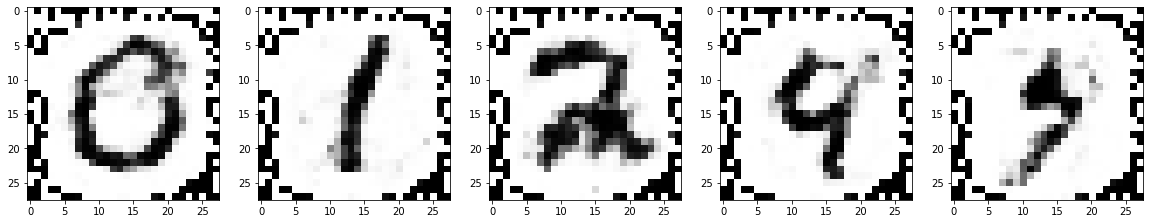

122/200 GEN_LOSS 1.7906 DISC_LOSS 0.3407(0.37)(0.32)


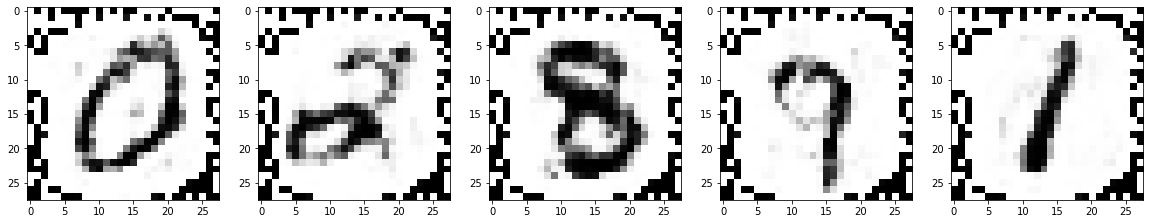

123/200 GEN_LOSS 1.1138 DISC_LOSS 0.6707(0.55)(0.79)


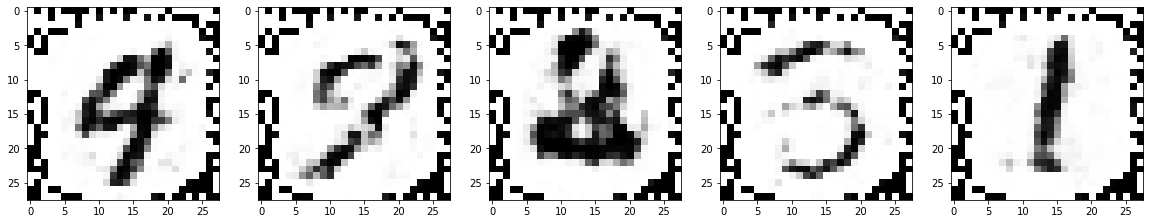

124/200 GEN_LOSS 1.8695 DISC_LOSS 0.1442(0.03)(0.25)


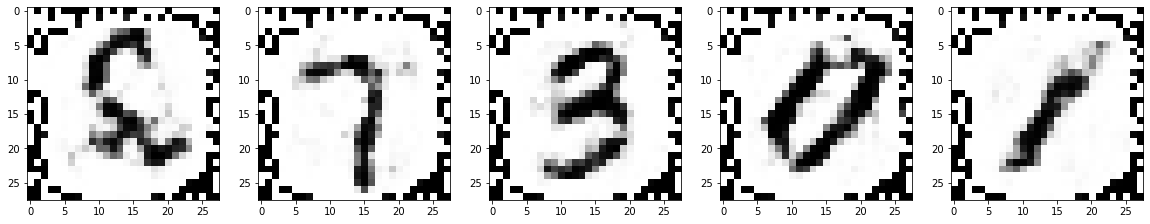

125/200 GEN_LOSS 1.3037 DISC_LOSS 0.3565(0.19)(0.52)


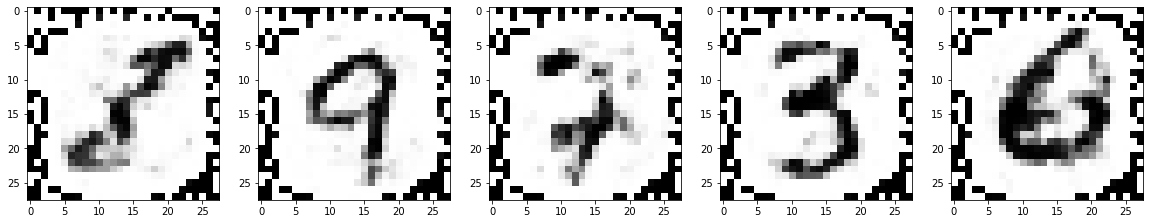

126/200 GEN_LOSS 1.3872 DISC_LOSS 0.5916(0.71)(0.47)


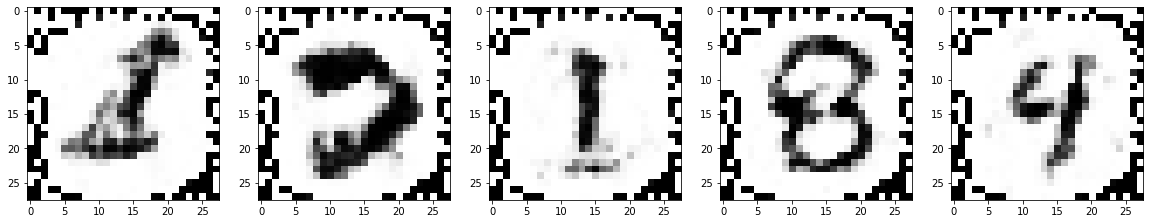

127/200 GEN_LOSS 1.0879 DISC_LOSS 1.5010(2.23)(0.77)


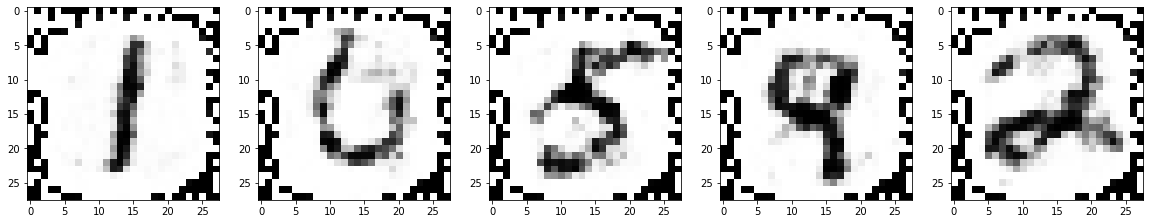

128/200 GEN_LOSS 1.4485 DISC_LOSS 0.6525(0.84)(0.47)


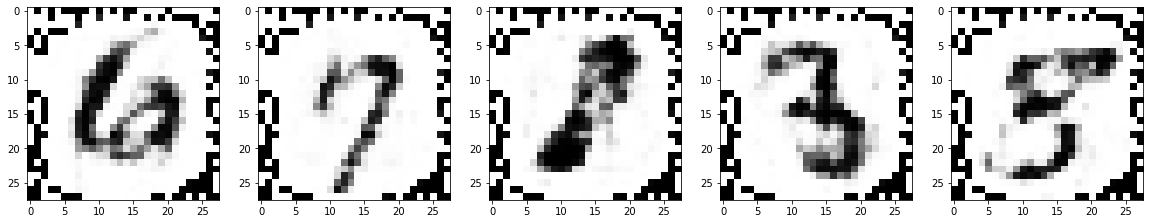

129/200 GEN_LOSS 2.1106 DISC_LOSS 0.6780(1.15)(0.21)


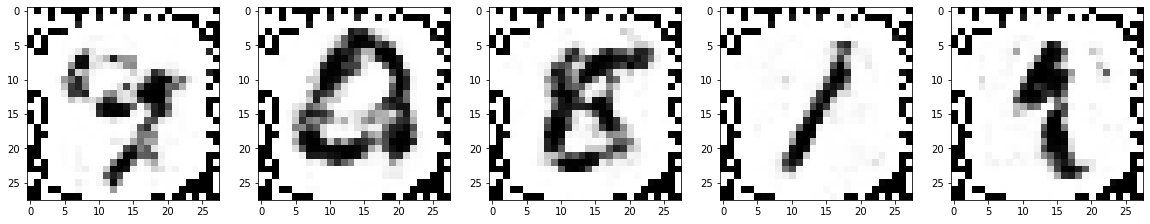

130/200 GEN_LOSS 1.8410 DISC_LOSS 0.2719(0.31)(0.23)


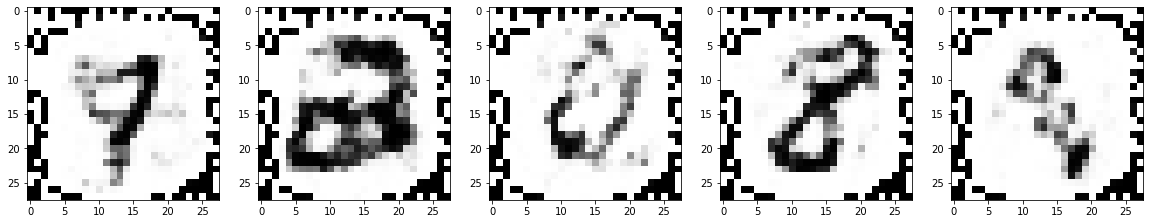

131/200 GEN_LOSS 1.5259 DISC_LOSS 0.3532(0.04)(0.66)


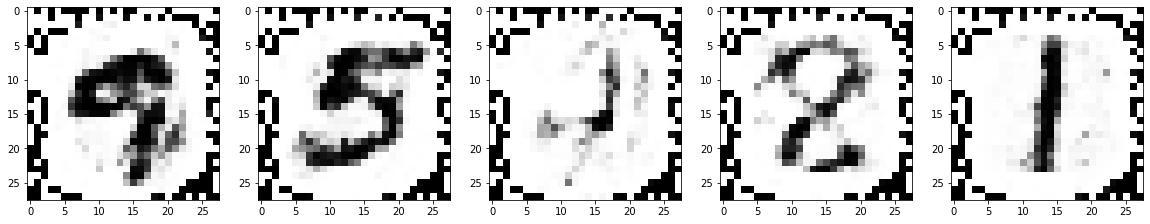

132/200 GEN_LOSS 1.8202 DISC_LOSS 0.1805(0.03)(0.33)


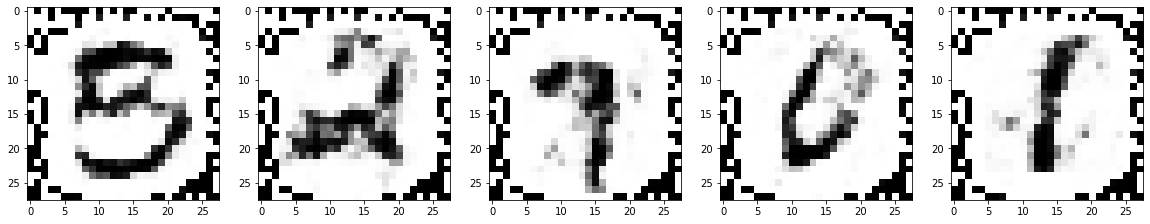

133/200 GEN_LOSS 1.9857 DISC_LOSS 0.5364(0.81)(0.26)


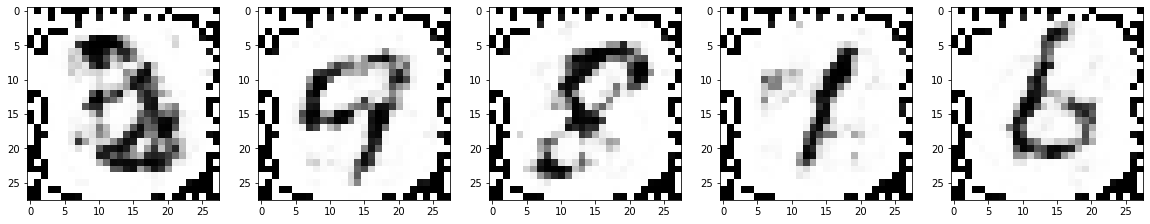

134/200 GEN_LOSS 1.8329 DISC_LOSS 1.9841(0.50)(3.47)


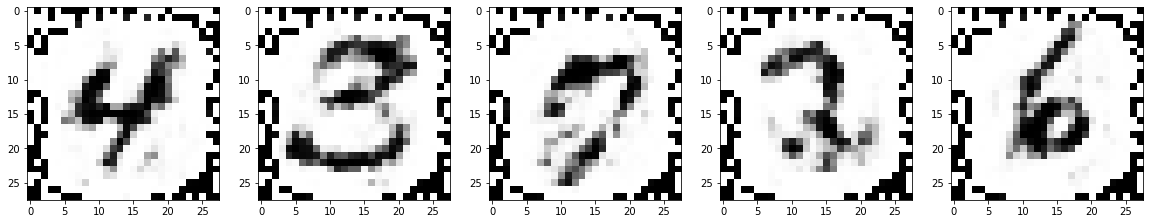

135/200 GEN_LOSS 2.3114 DISC_LOSS 0.5136(0.79)(0.24)


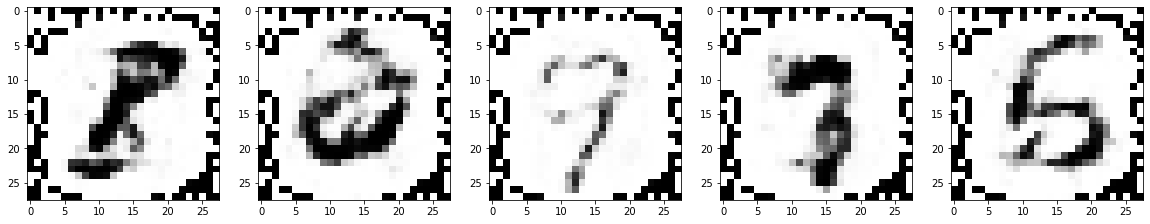

136/200 GEN_LOSS 2.7613 DISC_LOSS 1.9243(0.61)(3.23)


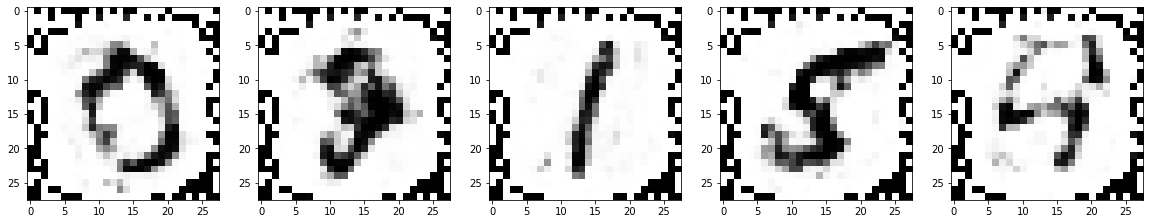

137/200 GEN_LOSS 1.7749 DISC_LOSS 0.4211(0.46)(0.38)


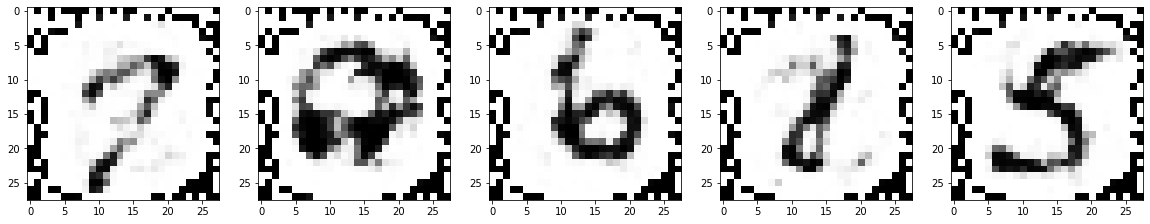

138/200 GEN_LOSS 1.6691 DISC_LOSS 0.4222(0.49)(0.36)


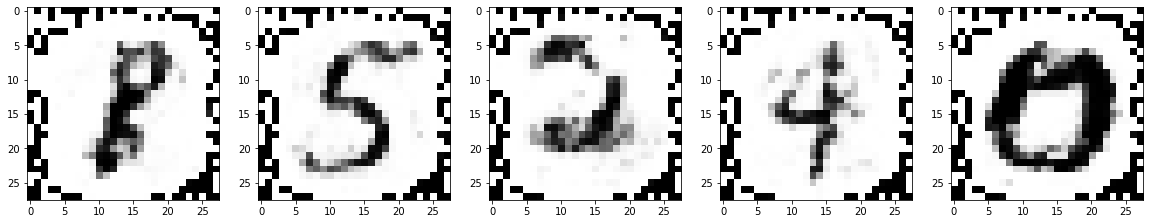

139/200 GEN_LOSS 1.4479 DISC_LOSS 0.4005(0.33)(0.47)


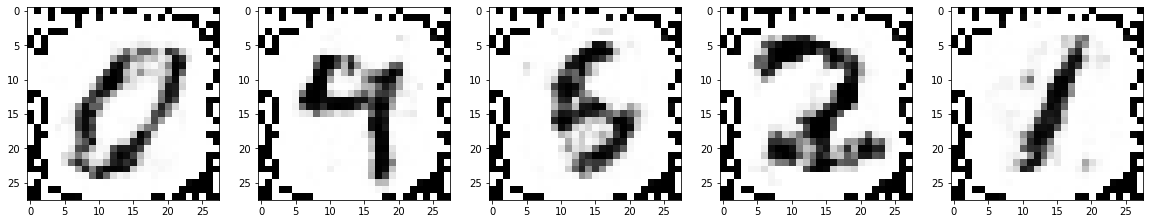

140/200 GEN_LOSS 1.3751 DISC_LOSS 0.2301(0.02)(0.44)


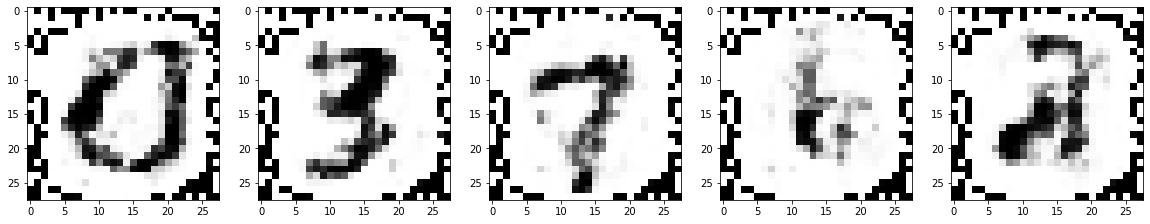

141/200 GEN_LOSS 2.0652 DISC_LOSS 0.3217(0.39)(0.26)


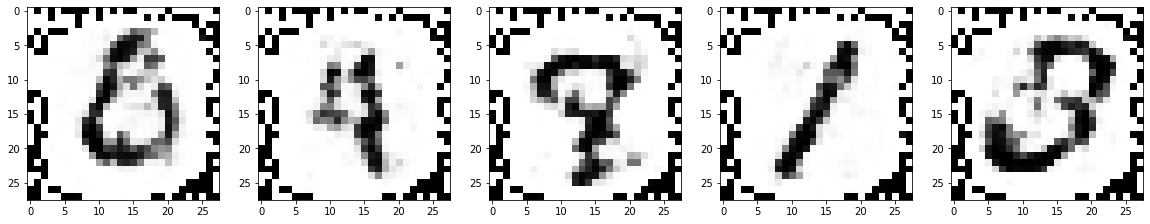

142/200 GEN_LOSS 1.2428 DISC_LOSS 0.7711(0.68)(0.86)


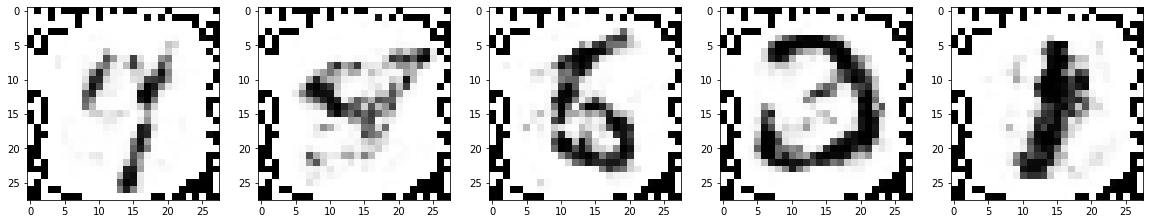

143/200 GEN_LOSS 1.8339 DISC_LOSS 0.5776(0.83)(0.33)


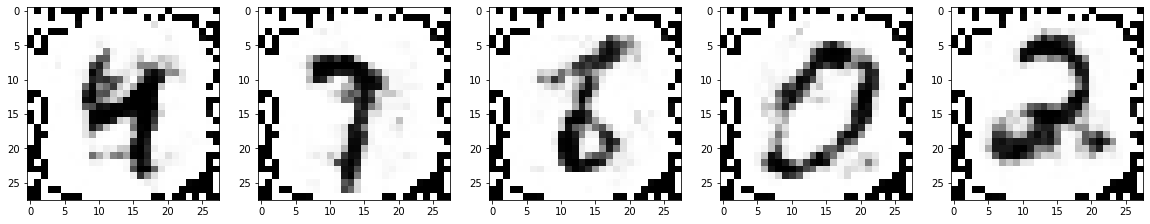

144/200 GEN_LOSS 2.1271 DISC_LOSS 0.6746(1.11)(0.24)


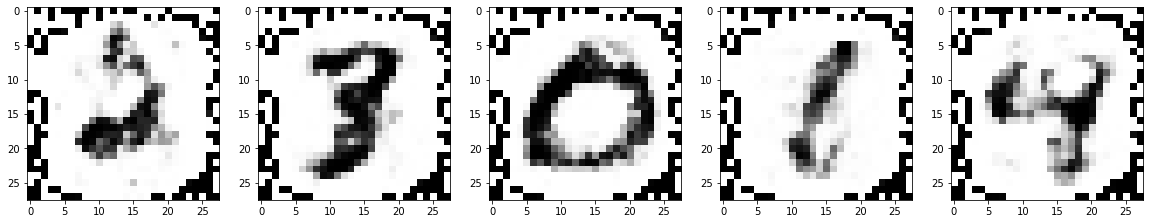

145/200 GEN_LOSS 1.5648 DISC_LOSS 0.7778(1.07)(0.48)


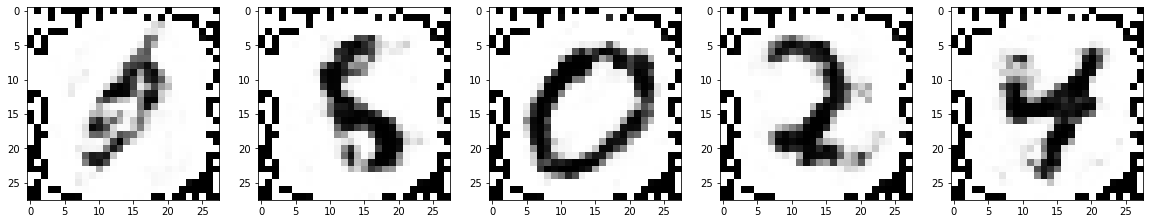

146/200 GEN_LOSS 1.6691 DISC_LOSS 0.6591(0.91)(0.41)


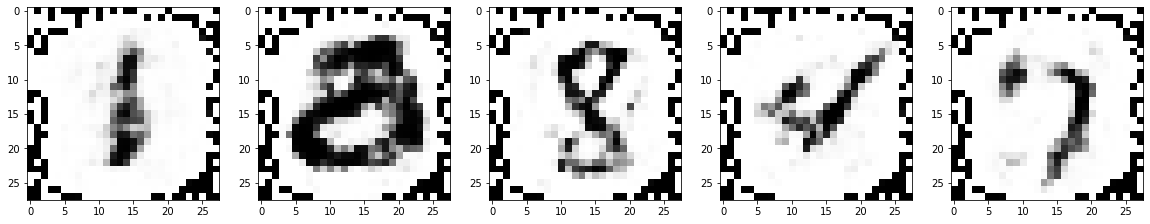

147/200 GEN_LOSS 2.0539 DISC_LOSS 0.3547(0.41)(0.30)


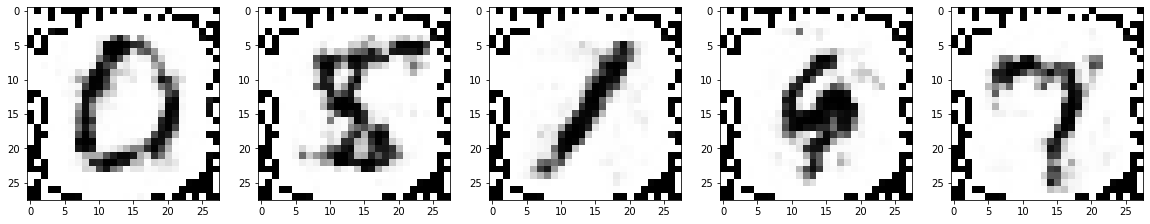

148/200 GEN_LOSS 2.4434 DISC_LOSS 0.6584(1.15)(0.17)


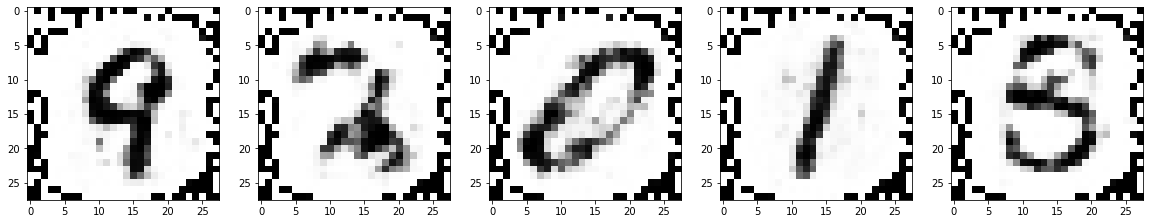

149/200 GEN_LOSS 2.0305 DISC_LOSS 0.1666(0.02)(0.31)


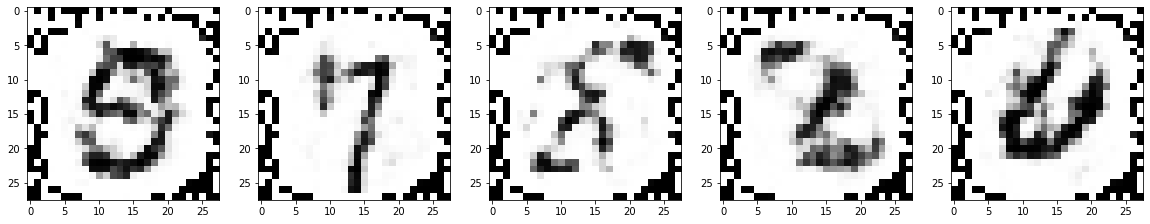

150/200 GEN_LOSS 1.9817 DISC_LOSS 0.6929(1.08)(0.31)


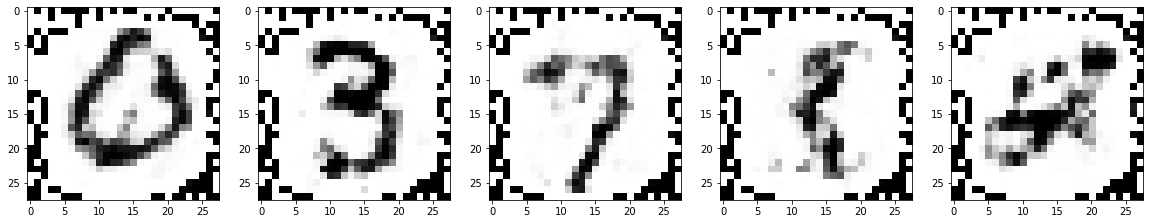

151/200 GEN_LOSS 2.1206 DISC_LOSS 0.6137(1.01)(0.21)


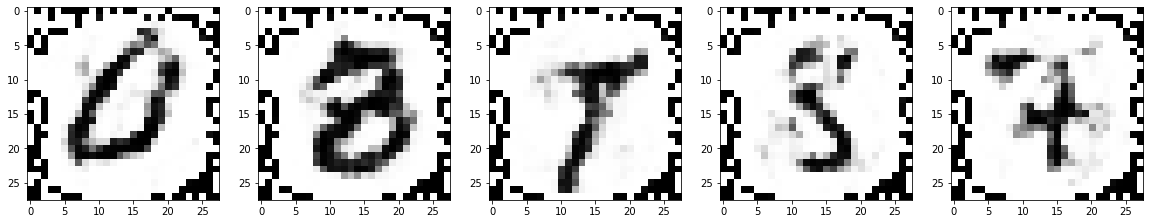

152/200 GEN_LOSS 2.2623 DISC_LOSS 0.7694(1.30)(0.24)


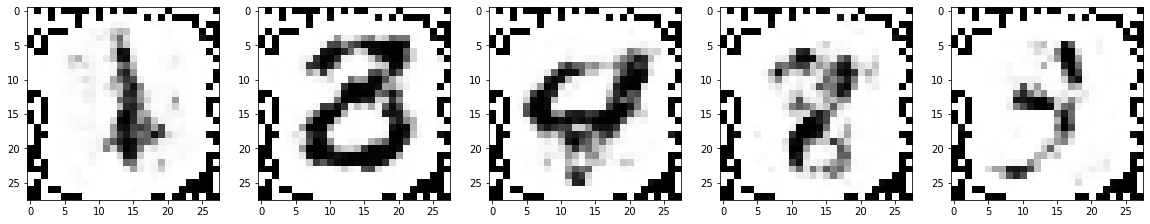

153/200 GEN_LOSS 1.8244 DISC_LOSS 0.1662(0.01)(0.32)


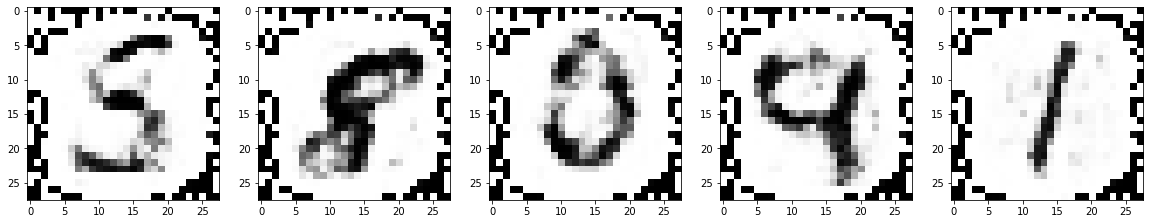

154/200 GEN_LOSS 1.6639 DISC_LOSS 0.7602(1.14)(0.38)


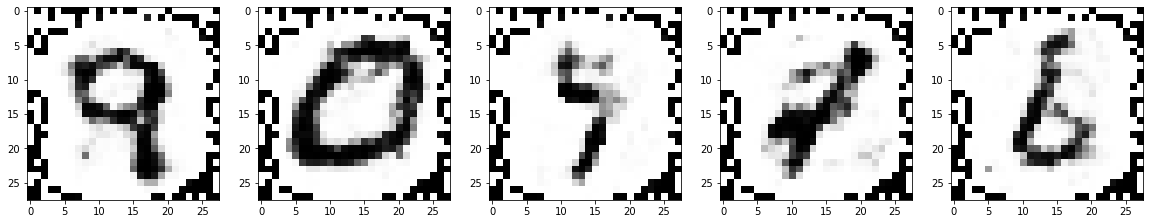

155/200 GEN_LOSS 1.8892 DISC_LOSS 0.5118(0.73)(0.30)


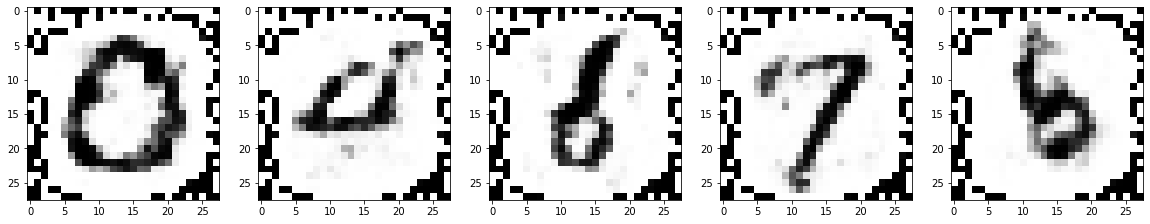

156/200 GEN_LOSS 2.8827 DISC_LOSS 0.5110(0.91)(0.11)


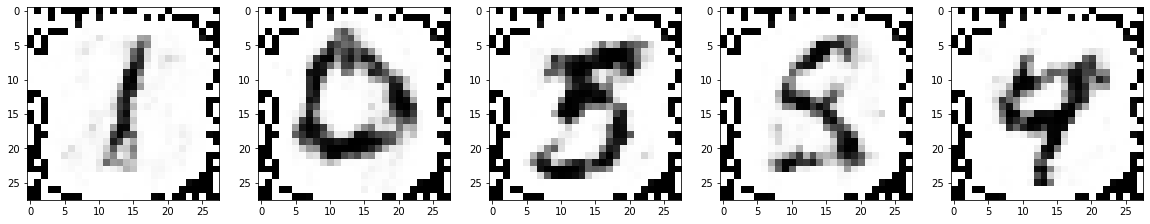

157/200 GEN_LOSS 2.0568 DISC_LOSS 0.2283(0.27)(0.19)


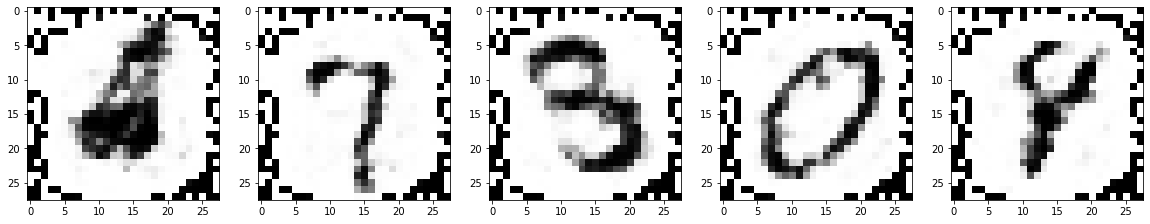

158/200 GEN_LOSS 2.5205 DISC_LOSS 0.4679(0.78)(0.16)


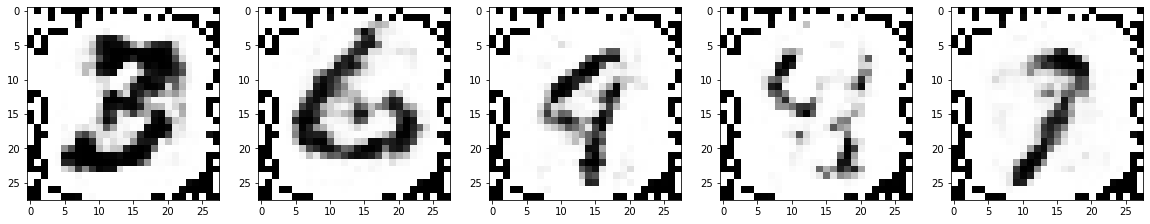

159/200 GEN_LOSS 2.0001 DISC_LOSS 0.1245(0.00)(0.25)


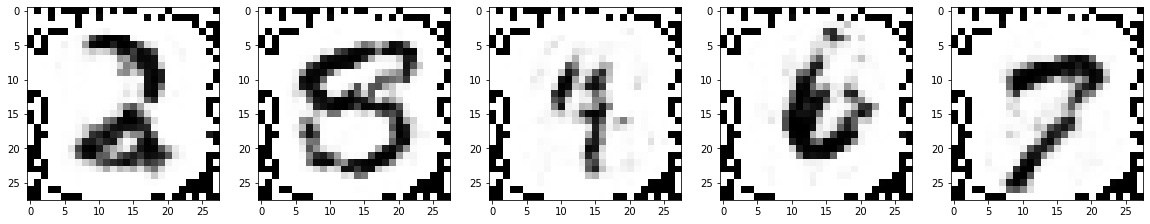

160/200 GEN_LOSS 1.7813 DISC_LOSS 0.6577(0.93)(0.38)


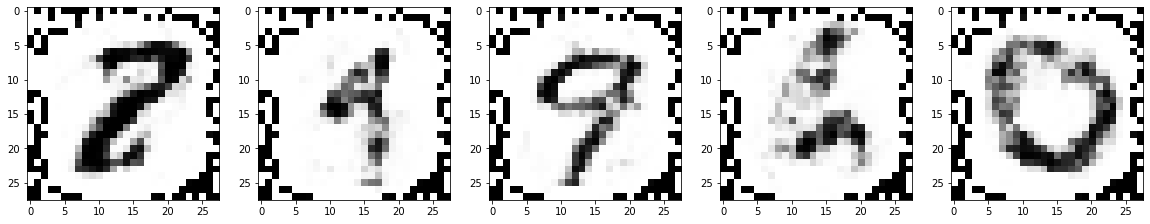

161/200 GEN_LOSS 2.3630 DISC_LOSS 0.1589(0.11)(0.21)


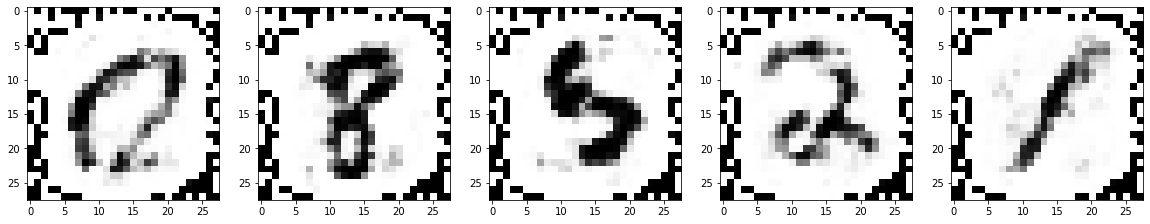

162/200 GEN_LOSS 1.1221 DISC_LOSS 1.0680(0.85)(1.29)


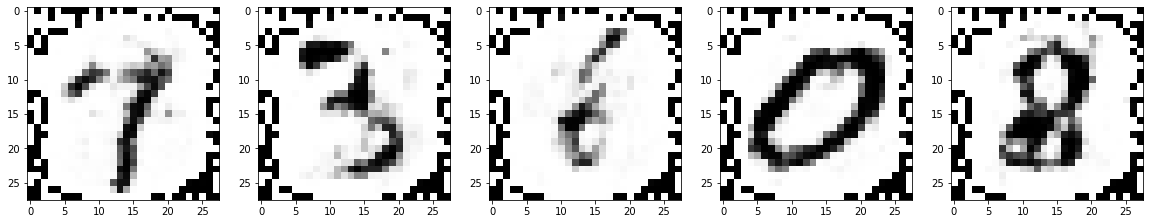

163/200 GEN_LOSS 2.0255 DISC_LOSS 0.7142(0.96)(0.47)


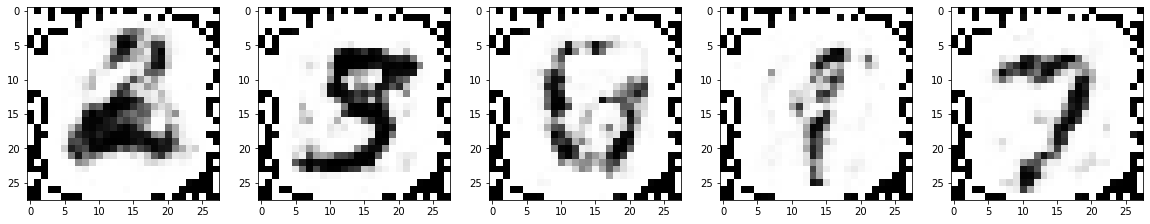

164/200 GEN_LOSS 1.8615 DISC_LOSS 0.2346(0.13)(0.33)


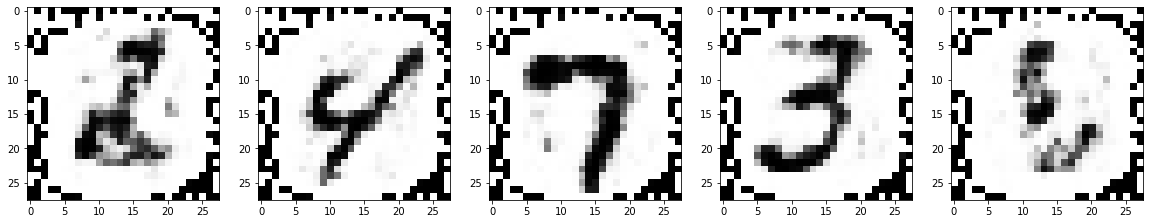

165/200 GEN_LOSS 1.6123 DISC_LOSS 0.2137(0.01)(0.42)


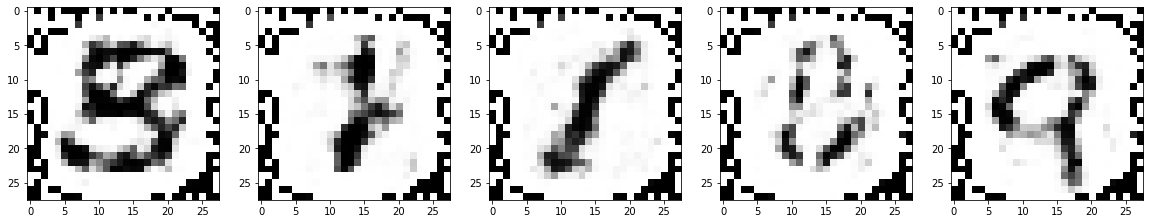

166/200 GEN_LOSS 1.7878 DISC_LOSS 0.1675(0.00)(0.33)


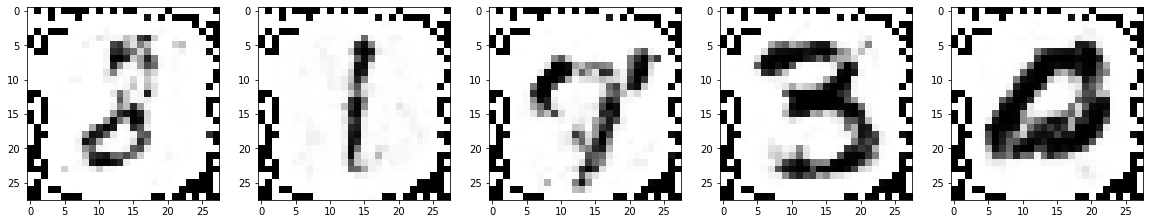

167/200 GEN_LOSS 1.0204 DISC_LOSS 0.4340(0.04)(0.83)


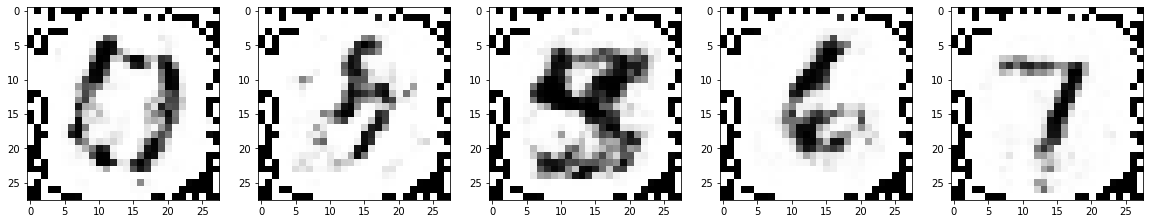

168/200 GEN_LOSS 1.2207 DISC_LOSS 0.8339(1.03)(0.63)


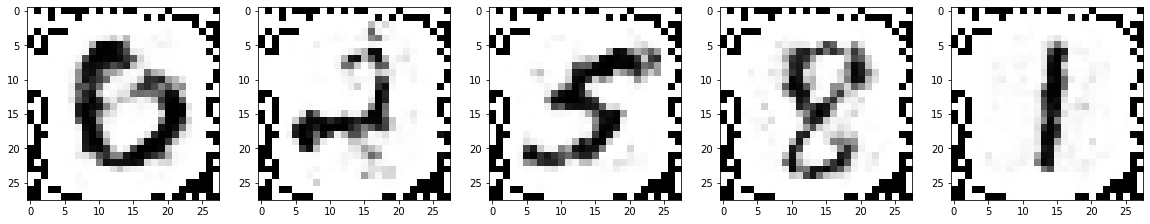

169/200 GEN_LOSS 2.1301 DISC_LOSS 0.4113(0.49)(0.33)


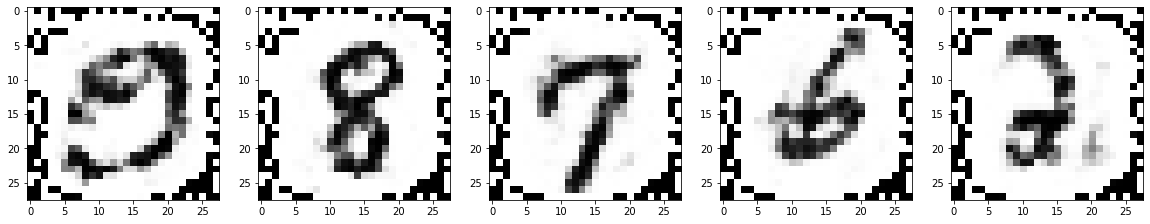

170/200 GEN_LOSS 2.8114 DISC_LOSS 0.2895(0.45)(0.13)


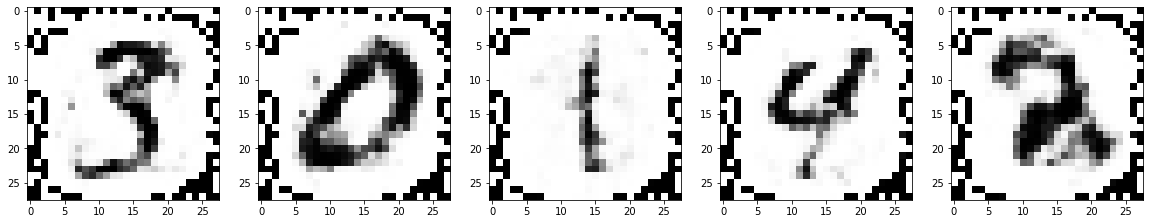

171/200 GEN_LOSS 2.3217 DISC_LOSS 0.5064(0.82)(0.19)


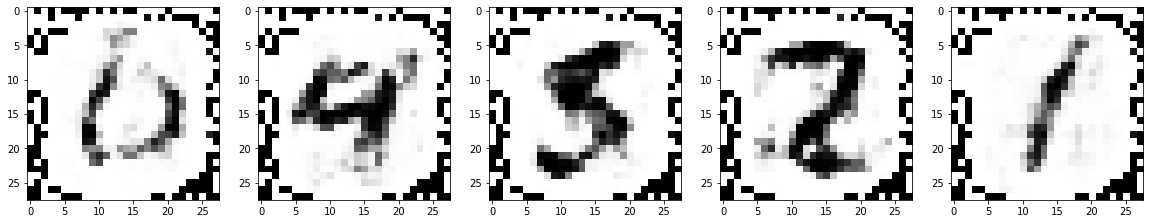

172/200 GEN_LOSS 2.4527 DISC_LOSS 0.3595(0.53)(0.19)


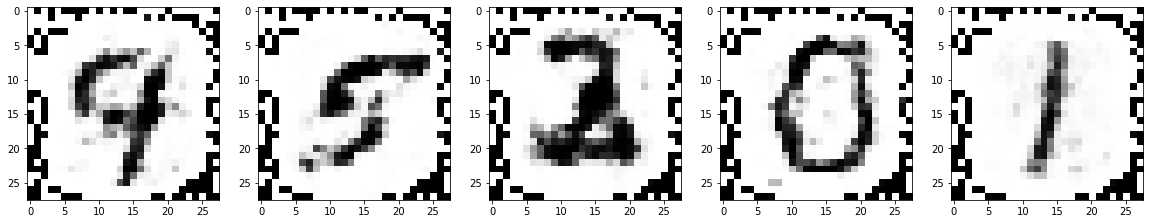

173/200 GEN_LOSS 2.1955 DISC_LOSS 0.9015(1.55)(0.25)


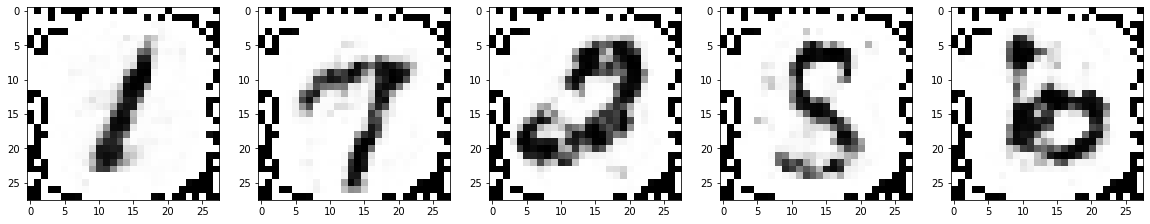

174/200 GEN_LOSS 1.8539 DISC_LOSS 0.4513(0.61)(0.29)


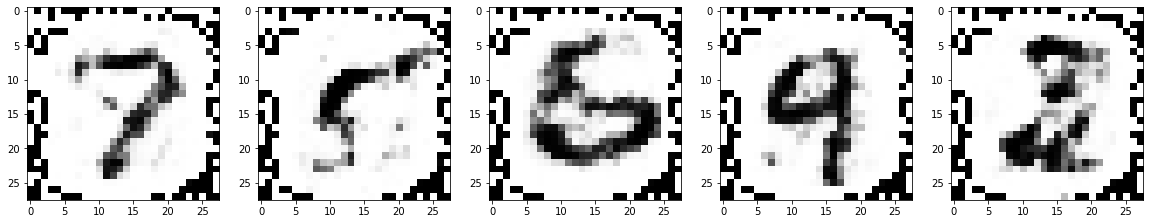

175/200 GEN_LOSS 2.1921 DISC_LOSS 0.8201(1.34)(0.30)


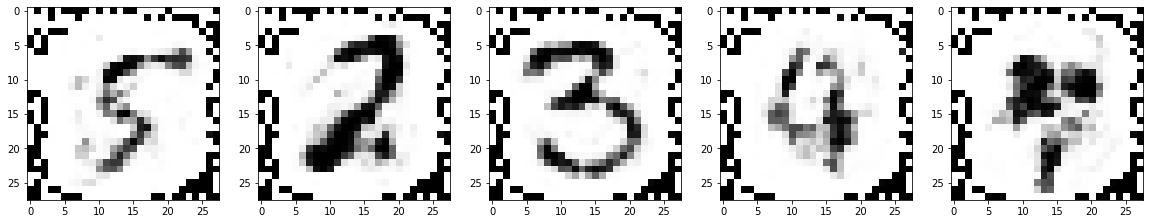

176/200 GEN_LOSS 2.6165 DISC_LOSS 0.9895(1.62)(0.36)


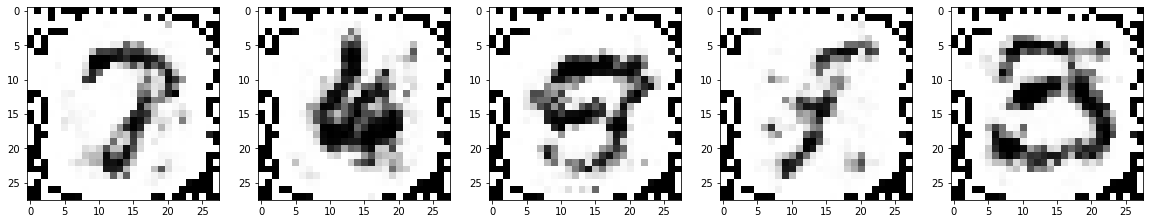

177/200 GEN_LOSS 1.9408 DISC_LOSS 0.2093(0.19)(0.23)


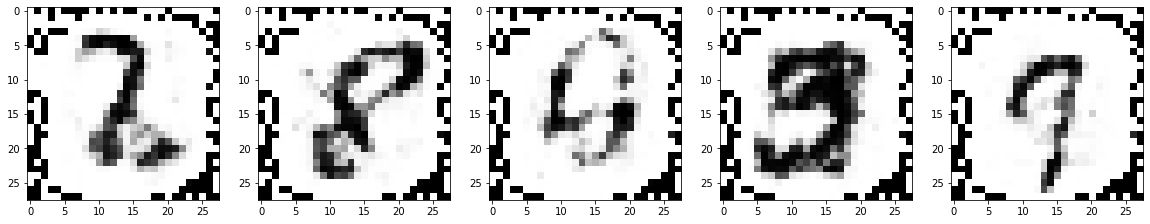

178/200 GEN_LOSS 2.4904 DISC_LOSS 0.8188(1.38)(0.26)


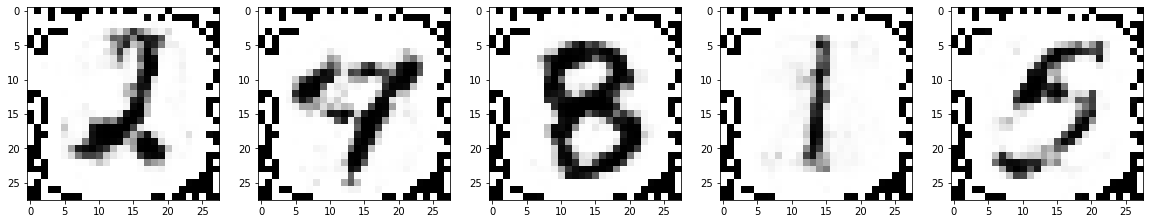

179/200 GEN_LOSS 1.9598 DISC_LOSS 0.6599(1.07)(0.25)


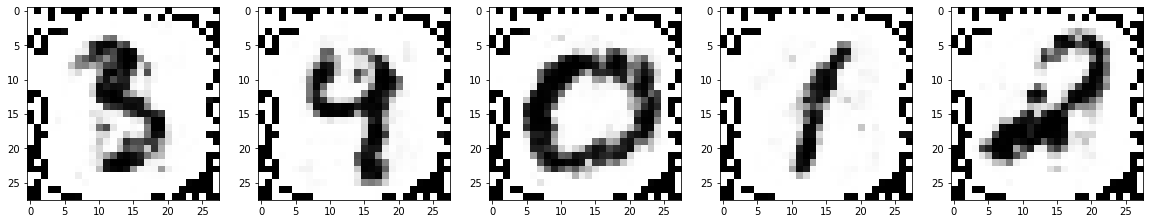

180/200 GEN_LOSS 2.8302 DISC_LOSS 0.0675(0.02)(0.11)


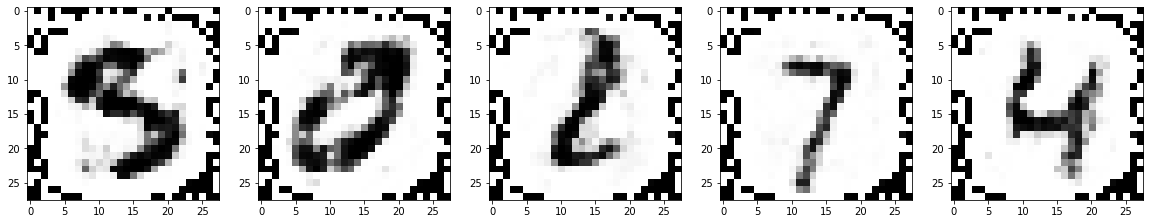

181/200 GEN_LOSS 1.6831 DISC_LOSS 0.8269(1.20)(0.45)


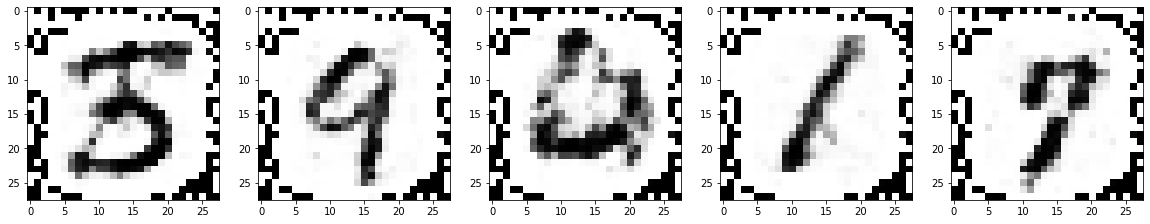

182/200 GEN_LOSS 1.2488 DISC_LOSS 1.0425(1.29)(0.79)


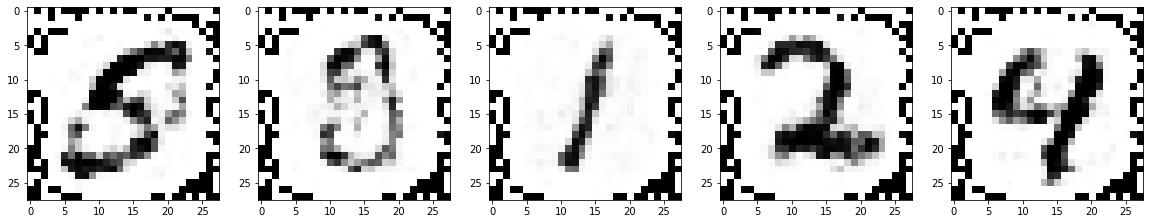

183/200 GEN_LOSS 2.4204 DISC_LOSS 0.1110(0.01)(0.21)


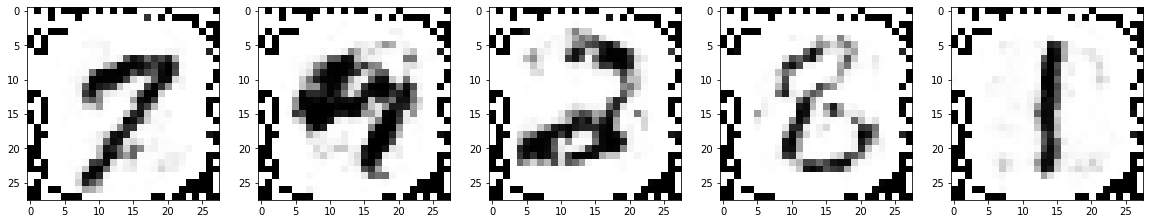

184/200 GEN_LOSS 1.7106 DISC_LOSS 0.2033(0.03)(0.38)


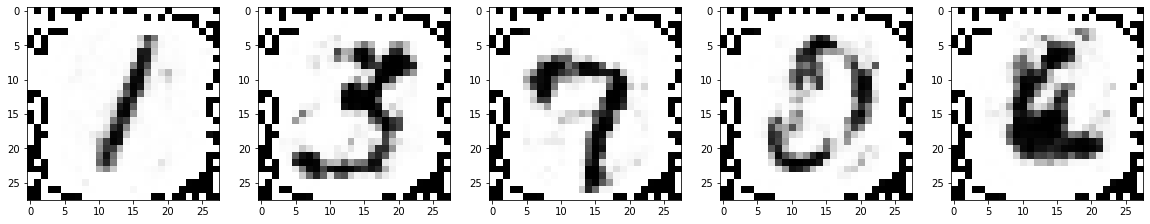

185/200 GEN_LOSS 1.8619 DISC_LOSS 0.1620(0.01)(0.31)


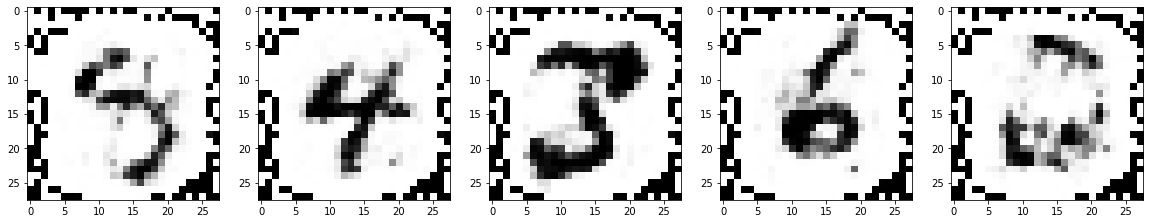

186/200 GEN_LOSS 1.3169 DISC_LOSS 0.7897(0.98)(0.60)


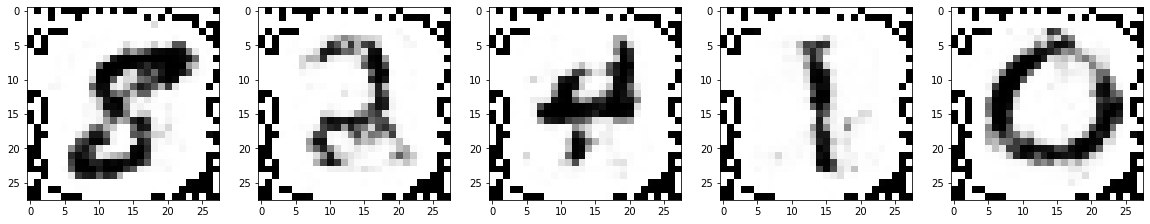

187/200 GEN_LOSS 2.7275 DISC_LOSS 0.6354(1.17)(0.10)


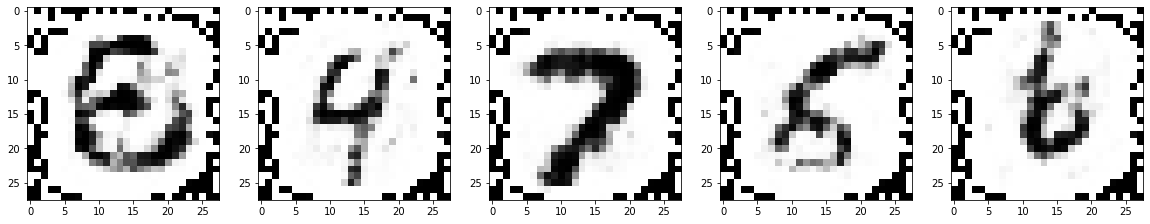

188/200 GEN_LOSS 1.8843 DISC_LOSS 0.6065(0.90)(0.32)


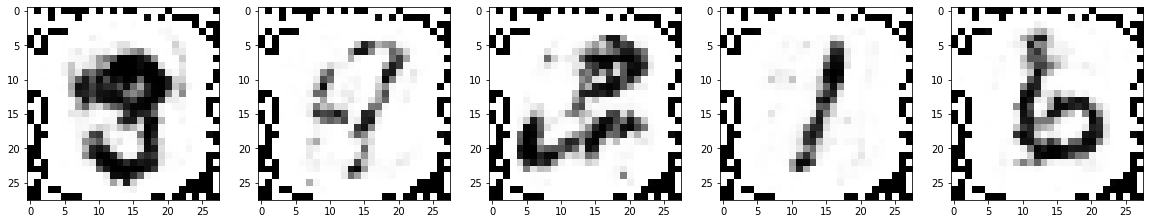

189/200 GEN_LOSS 2.2831 DISC_LOSS 0.0939(0.01)(0.18)


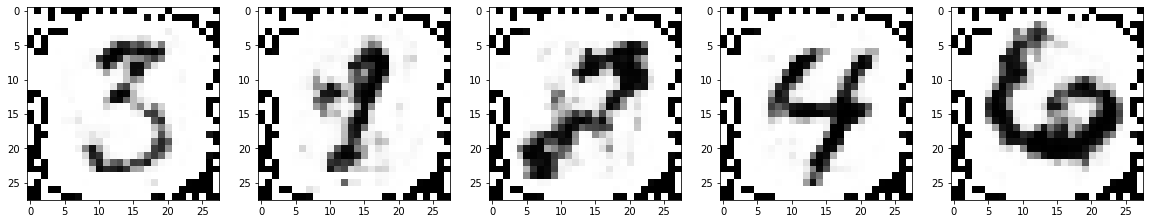

190/200 GEN_LOSS 2.0769 DISC_LOSS 0.4275(0.16)(0.70)


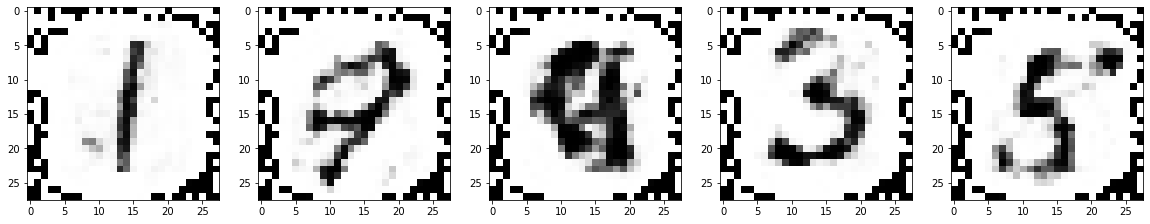

191/200 GEN_LOSS 2.6573 DISC_LOSS 0.1132(0.07)(0.16)


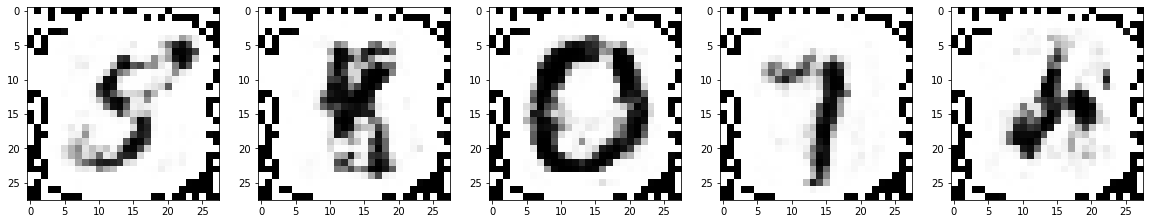

192/200 GEN_LOSS 2.2202 DISC_LOSS 0.0937(0.00)(0.19)


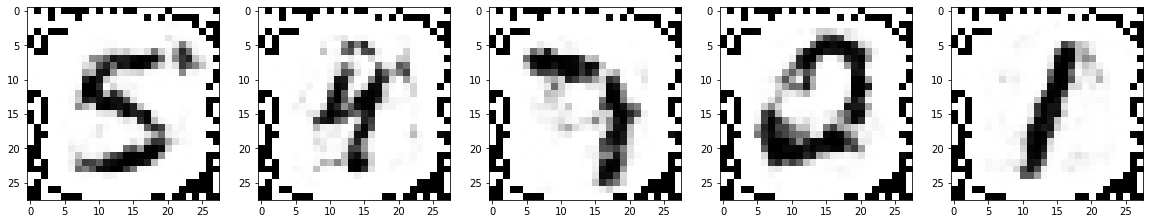

193/200 GEN_LOSS 2.0466 DISC_LOSS 0.7591(1.14)(0.37)


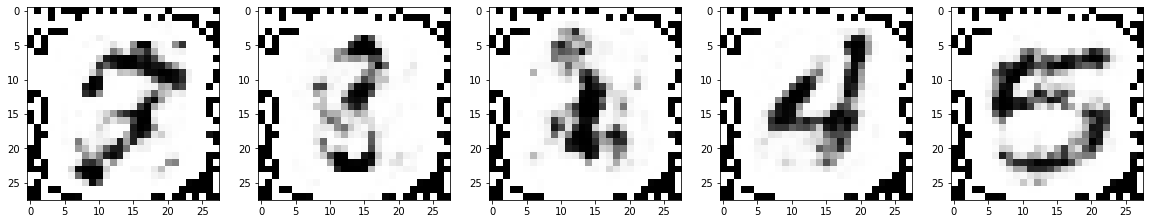

194/200 GEN_LOSS 1.6236 DISC_LOSS 0.3157(0.00)(0.63)


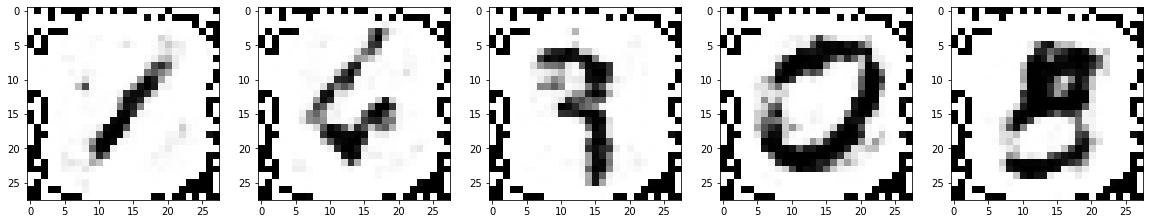

195/200 GEN_LOSS 2.4882 DISC_LOSS 0.7176(1.20)(0.24)


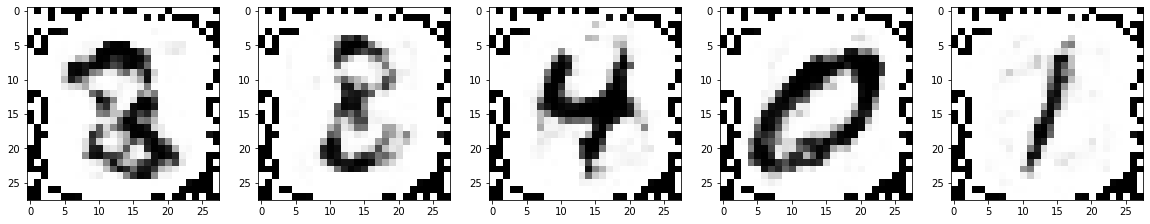

196/200 GEN_LOSS 1.8865 DISC_LOSS 0.5233(0.71)(0.34)


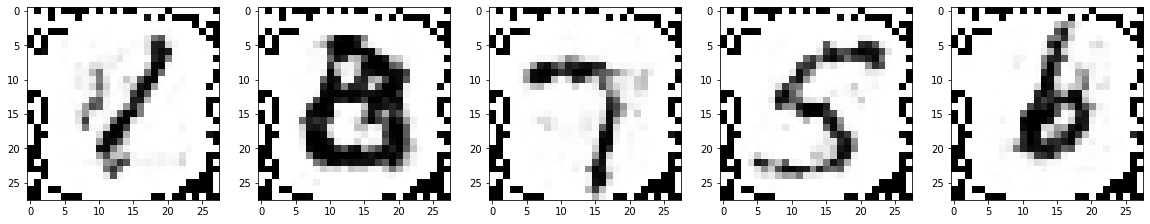

197/200 GEN_LOSS 1.8054 DISC_LOSS 1.2864(1.16)(1.41)


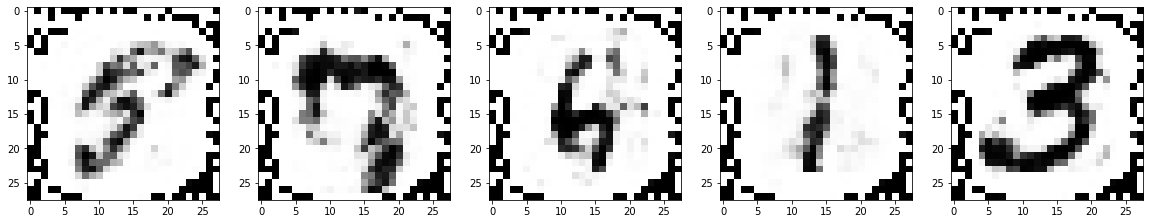

198/200 GEN_LOSS 2.3421 DISC_LOSS 0.1257(0.08)(0.17)


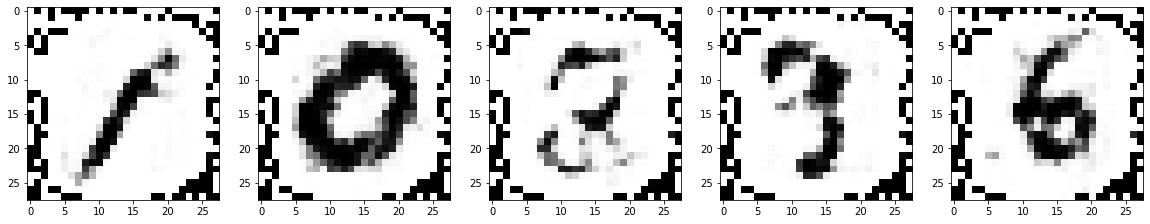

199/200 GEN_LOSS 2.2132 DISC_LOSS 0.1319(0.08)(0.19)


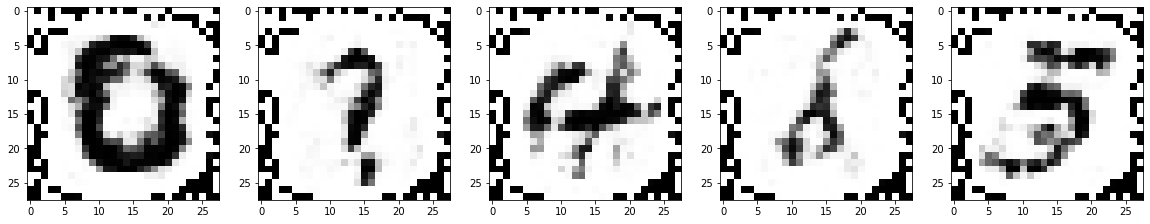

200/200 GEN_LOSS 2.4103 DISC_LOSS 0.2830(0.38)(0.18)


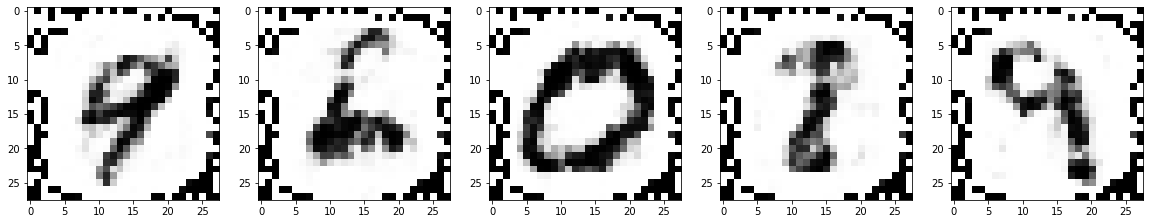

In [ ]:
gen = Generator()

# 200 epochs should be enough to give us some recognizable digits
train(gen, 200)